# Setup

## Import libs

In [620]:
import numpy as np
import matplotlib.pyplot as plt
import src.bayesian_stats as bst
import os
import pandas as pd
import arviz as az
import pymc as pm
from scipy import stats
from scipy.stats import norm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.3.0


## Define functions

In [3]:
def bayesian_two_factor_anova_robust(x1, x2, y, n_draws=1000):
    """Bayesian analogue of two-factor ANOVA.
    
    Models instance of outcome resulting from two categorical predictors.
    
    Args:
        x1: First categorical predictor variable.
        x2: Second categorical predictor variable.
        y: The outcome variable.
    
    Returns:
        PyMC Model and InferenceData objects.
    """
    mu_y = y.mean()
    sigma_y = y.std()

    a_shape, a_rate = bst.gamma_shape_rate_from_mode_sd(sigma_y / 2 , 2 * sigma_y)
    x1_vals, levels1, n_levels1 = bst.parse_categorical(x1)
    x2_vals, levels2, n_levels2 = bst.parse_categorical(x2)

    with pm.Model(coords={"factor1": levels1, "factor2": levels2}) as model:
        # To understand the reparameterization, see:
        # http://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/ 
        a0_tilde = pm.Normal('a0_tilde', mu=0, sigma=1)
        a0 = pm.Deterministic('a0', mu_y + sigma_y * 5 * a0_tilde)

        sigma_a1 = pm.Gamma('sigma_a1', a_shape, a_rate)
        a1_tilde = pm.Normal('a1_tilde', mu=0, sigma=1, dims="factor1")
        a1 = pm.Deterministic('a1', 0.0 + sigma_a1*a1_tilde)

        sigma_a2 = pm.Gamma('sigma_a2', a_shape, a_rate)
        a2_tilde = pm.Normal('a2_tilde', mu=0, sigma=1, dims="factor2")
        a2 = pm.Deterministic('a2', 0.0 + sigma_a2*a2_tilde)

        sigma_a1a2 = pm.Gamma('sigma_a1a2', a_shape, a_rate)
        a1a2_tilde = pm.Normal('a1a2_tilde', mu=0, sigma=1, dims=("factor1", "factor2"))
        a1a2 = pm.Deterministic('a1a2', 0.0 + sigma_a1a2 * a1a2_tilde)

        mu = a0 + a1[x1_vals] + a2[x2_vals] +a1a2[x1_vals, x2_vals]
        # sigma = pm.Uniform('sigma', sigma_y / 100, sigma_y * 10)

        # Hyperparameters 
        sigma_y_sd = pm.Gamma('sigma_y_sd', alpha=a_shape, beta=a_rate)
        sigma_y_mode = pm.Gamma("sigma_y_mode", alpha=a_shape, beta=a_rate)
        sigma_y_rate = (sigma_y_mode + np.sqrt(sigma_y_mode**2 + 4 * sigma_y_sd**2)) / 2 * sigma_y_sd**2
        sigma_y_shape = sigma_y_mode * sigma_y_rate
        sigma_y = pm.Gamma("sigma", alpha=sigma_y_shape, beta=sigma_y_rate, dims=("factor1", "factor2"))
        nu_minus1 = pm.Exponential('nu_minus1', 1 / 29)
        nu = pm.Deterministic('nu', nu_minus1 + 1)
        
        # Define the likelihood function
        # likelihood = pm.Normal('likelihood', mu, sigma=sigma, observed=y) 
        likelihood = pm.StudentT('likelihood', nu=nu, mu=mu, sigma=sigma_y[x1_vals,x2_vals], observed=y)

        # Sample from the posterior
        idata = pm.sample(draws=n_draws, target_accept=0.95)
        
        return model, idata

## Load data

In [527]:
#Change the directory
os.chdir('/Users/jonathanwood/Documents/GitHub/Reinforcement-learning-in-locomotion/Data')

df1 = pd.read_csv('E1_results_anova.txt')
df1_var = pd.read_csv('E1_variability_anova.txt')
df1_reg = pd.read_csv('E1_results_regress.txt')
df2 = pd.read_csv('E2_results_anova.txt')
df2_var = pd.read_csv('E2_variability_anova.txt')

# Experiment 1

## End of learning differences

In [124]:
#Run the model
model_lrn_e1, idata_lrn_e1 = bst.BEST(df1.learning[df1.time=="Late"], df1.group[df1.time=="Late"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_mean, group_std, nu_minus_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


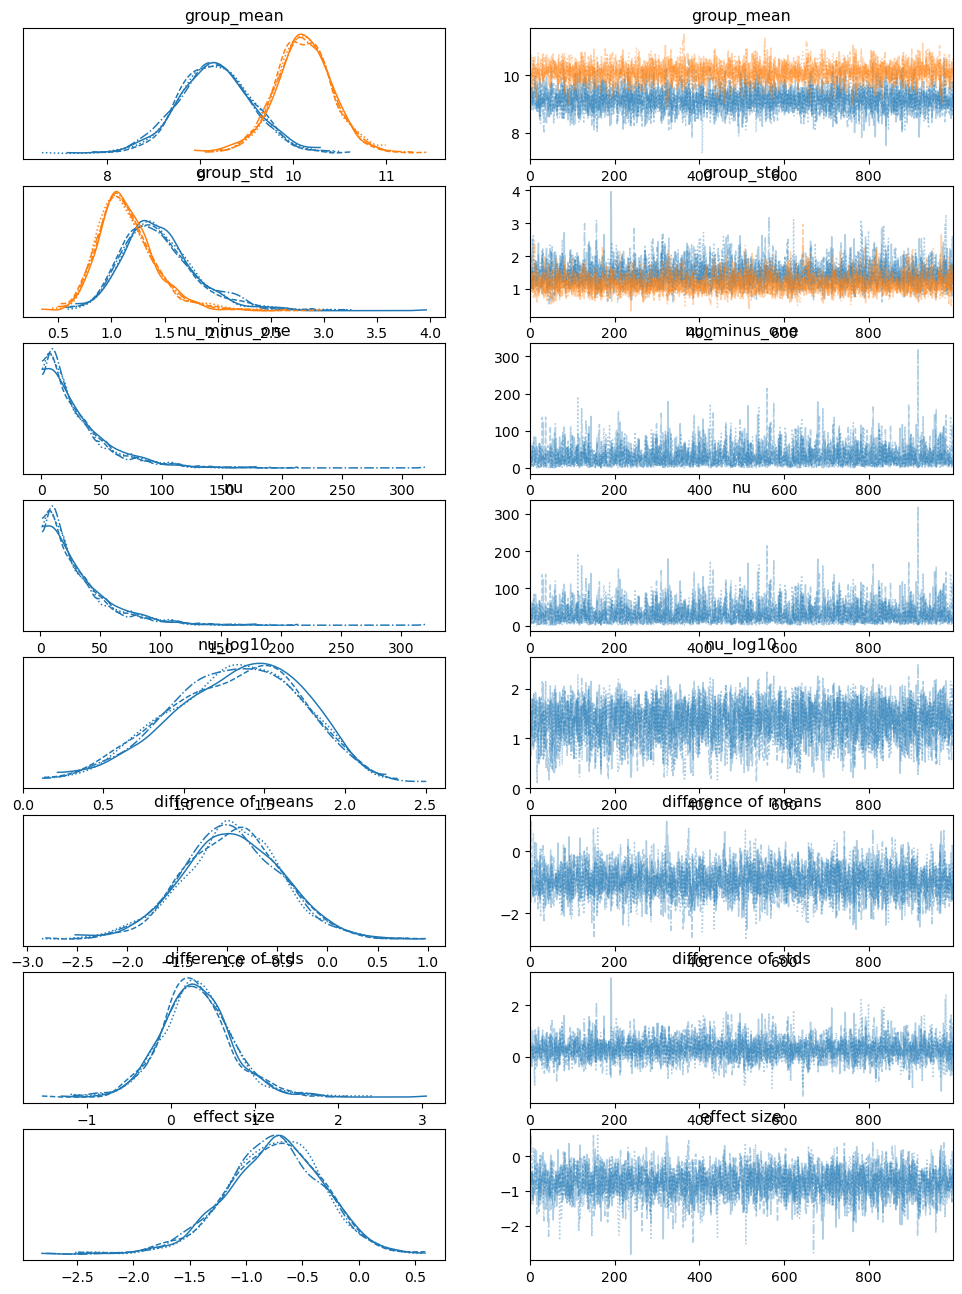

In [621]:
az.plot_trace(idata_lrn_e1);

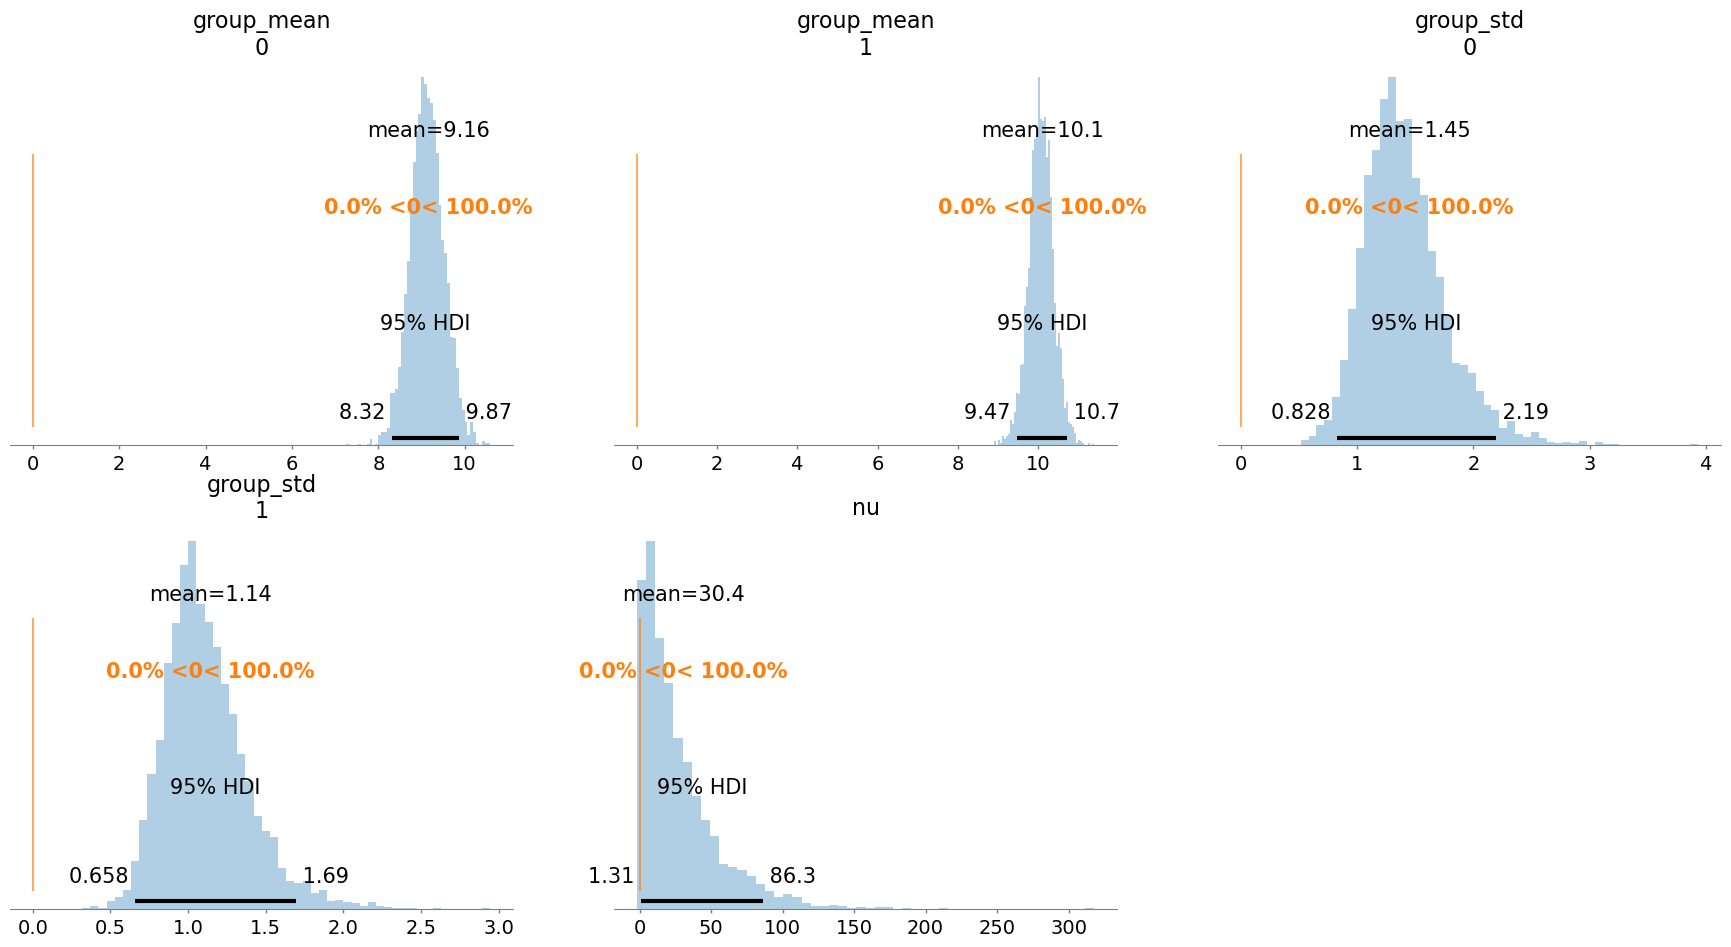

In [118]:
az.plot_posterior(
    idata_lrn_e1,
    var_names=["group_mean", "group_std", "nu"],
    kind="hist",
    round_to=3,
    bins=50,
    hdi_prob=0.95,
    ref_val=0,
);

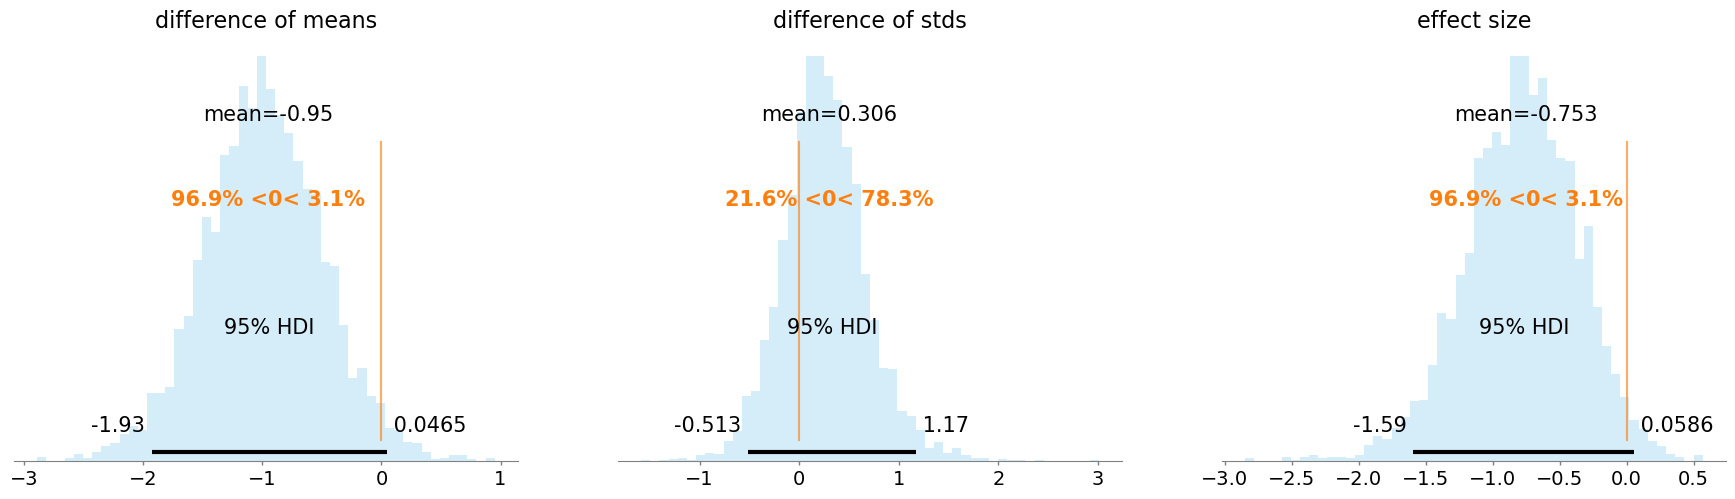

In [119]:
az.plot_posterior(
    idata_lrn_e1,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
    kind="hist",
    round_to=3,
    bins=50,
    hdi_prob=0.95,
);

In [323]:
e1_endlrn_summary = az.summary(idata_lrn_e1,hdi_prob=0.95)

print('RPE Total Learning =', e1_endlrn_summary['mean'][0], '[', e1_endlrn_summary['hdi_2.5%'][0], e1_endlrn_summary['hdi_97.5%'][0], ']')
print('TE Total Learning =', e1_endlrn_summary['mean'][1], '[', e1_endlrn_summary['hdi_2.5%'][1], e1_endlrn_summary['hdi_97.5%'][1], ']')
print('Difference of means =', e1_endlrn_summary['mean'][7], '[', e1_endlrn_summary['hdi_2.5%'][7], e1_endlrn_summary['hdi_97.5%'][7], ']')

RPE Total Learning = 9.161 [ 8.318 9.869 ]
TE Total Learning = 10.111 [ 9.466 10.721 ]
Difference of means = -0.95 [ -1.931 0.047 ]


## Error differences 

In [325]:
model_err_e1, idata_err_e1 = bayesian_two_factor_anova_robust(df1.group, df1.time, df1.error, n_draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0_tilde, sigma_a1, a1_tilde, sigma_a2, a2_tilde, sigma_a1a2, a1a2_tilde, sigma_y_sd, sigma_y_mode, sigma, nu_minus1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 264 seconds.


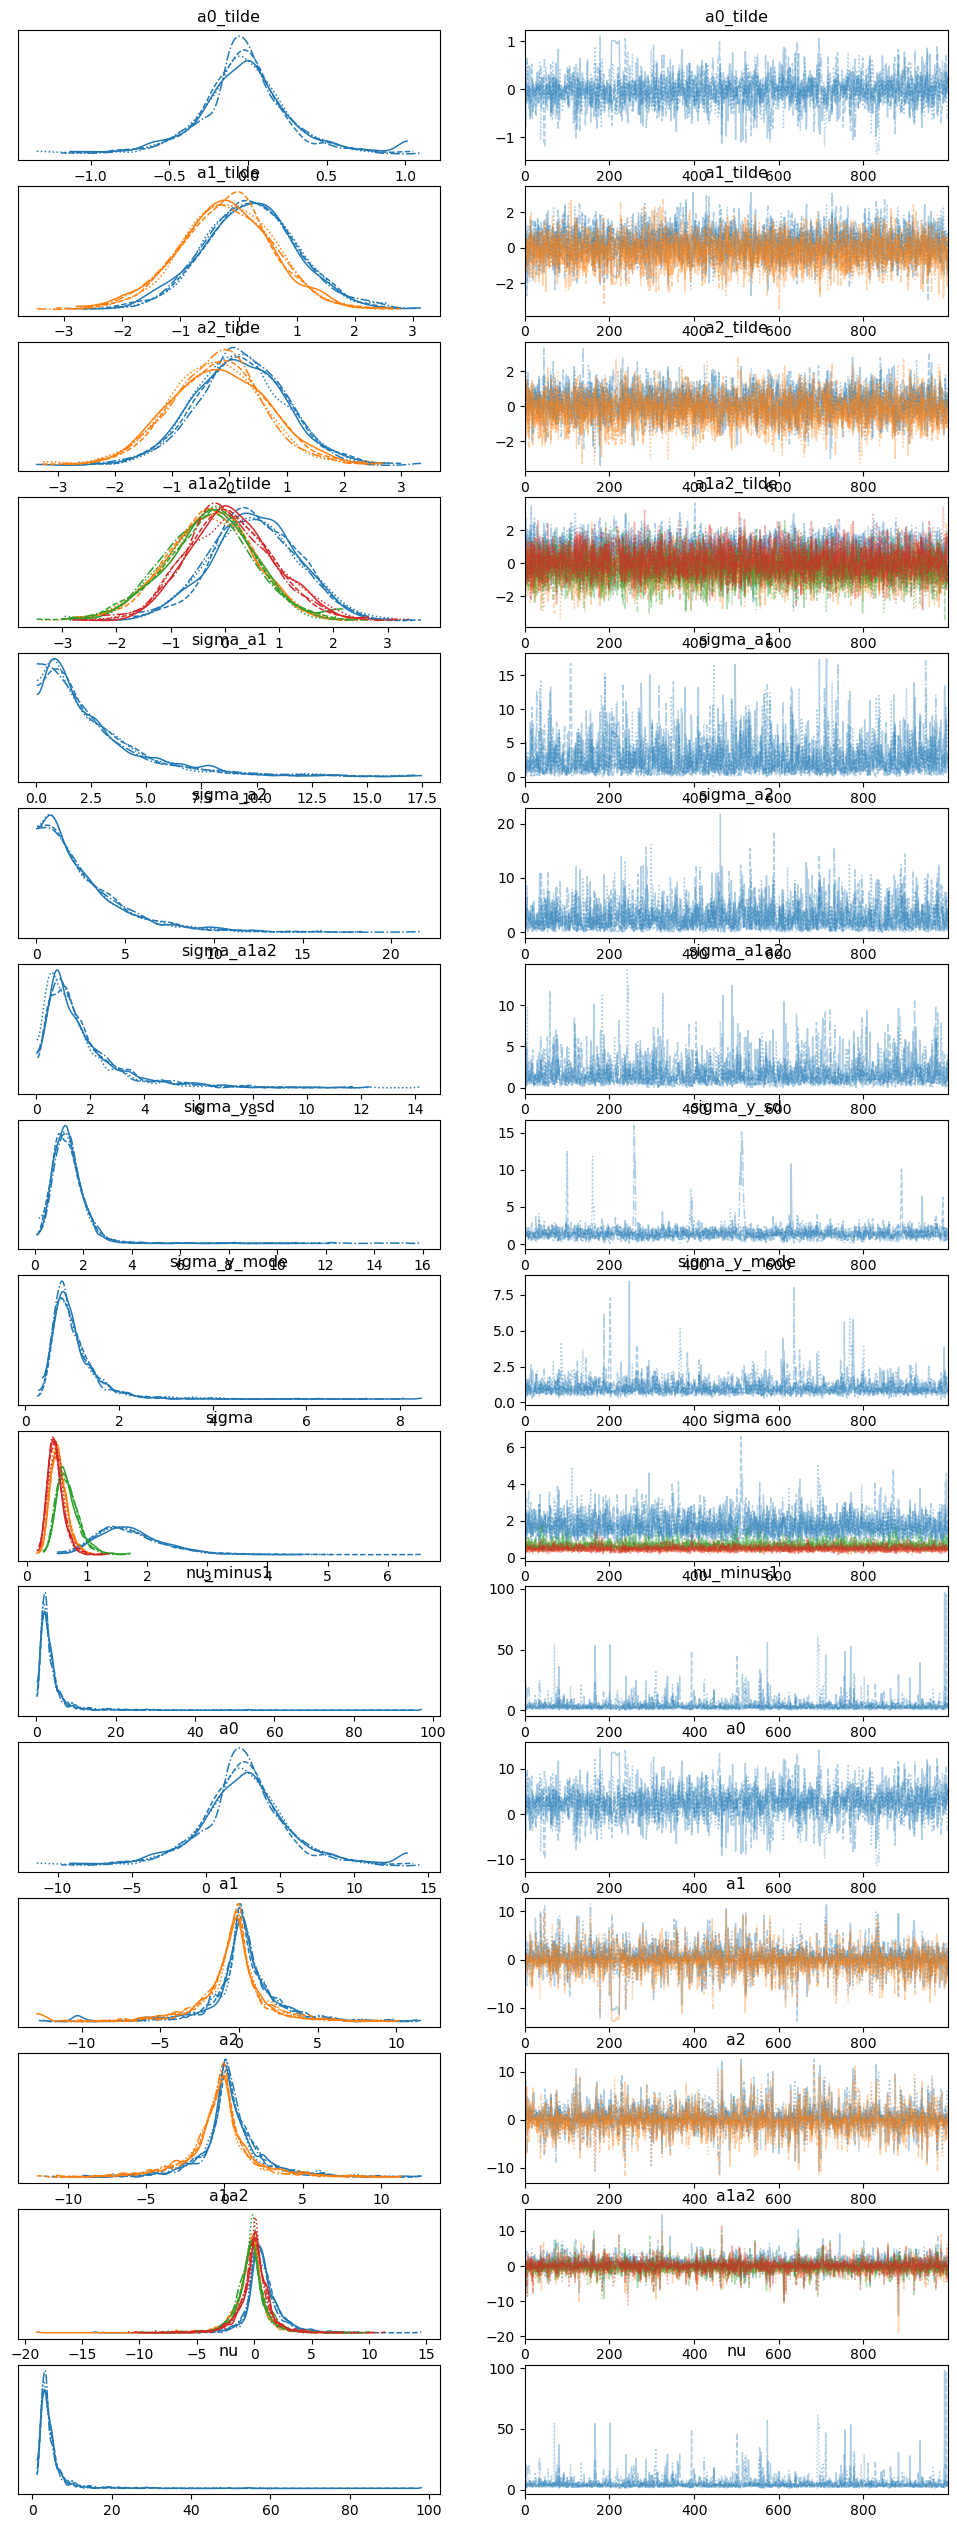

In [588]:
az.plot_trace(idata_err_e1);

In [619]:
# Convert coefficients to sum-to-zero deflections
post_err_e1 = bst.two_factor_anova_convert_to_sum_to_zero(idata_err_e1, df1.group, df1.time)
# Rename the dimensions for easier label-based indexing
post_err_e1 = post_err_e1.rename({"factor1": "group", "factor2": "time"})
# post_err_e1.b2.sel(time='Early')
post_err_e1.sigma.sel(time='Early')

<xarray.DataArray 'sigma' (group: 2, sample: 4000)>
array([[1.46387699, 1.03857228, 1.46912588, ..., 0.97033013, 1.48497766,
        1.33000542],
       [0.55404003, 0.62833198, 0.86333683, ..., 0.89256376, 0.37810556,
        0.38891394]])
Coordinates:
  * group    (group) <U3 'RPE' 'TE'
    time     <U5 'Early'
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999

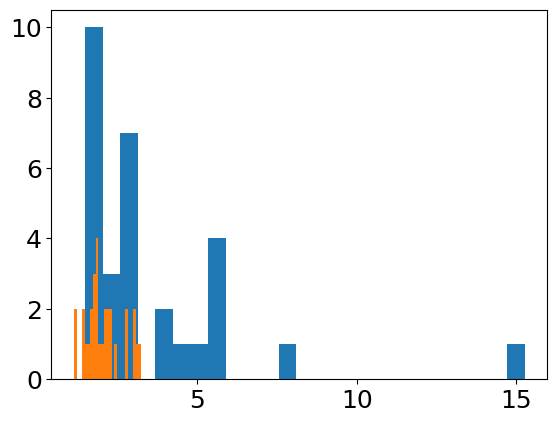

In [617]:
x = np.linspace(-20,20)


plt.hist(df1.error[df1.time=='Early'],bins=25);

plt.hist(df1.error[df1.time=='Late'],bins=25);


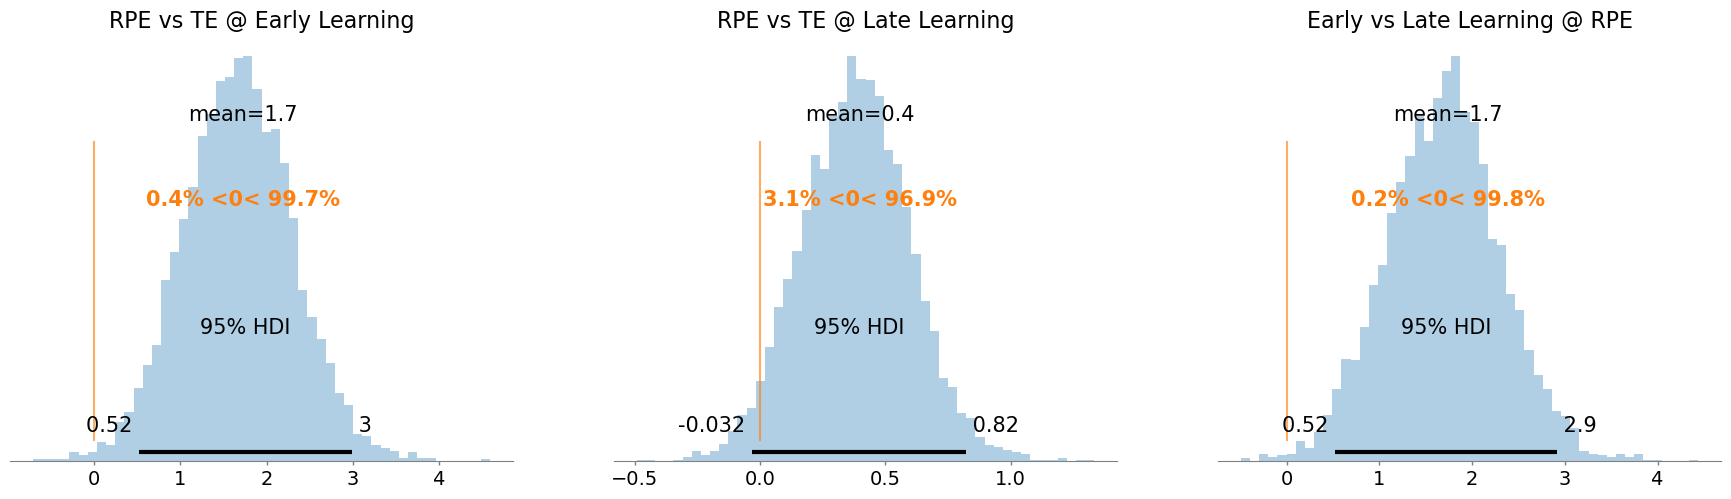

In [488]:

# #Main effect constrasts
# contrasts = {"RPE vs TE": post_err_e1.b1.sel(group='RPE') - post_err_e1.b1.sel(group='TE'),
#             "Early vs Late": post_err_e1.b2.sel(time='Early') - post_err_e1.b2.sel(time='Late')}
# az.plot_posterior(contrasts, 
#                   kind="hist", 
#                   combine_dims={"sample"},
#                   bins=50, 
#                   point_estimate="mean", 
#                   ref_val=0,
#                   hdi_prob=0.95);

interaction_contrasts = {"RPE vs TE @ Early Learning": post_err_e1.m.sel(group="RPE", time="Early") - post_err_e1.m.sel(group="TE", time="Early"),
                         "RPE vs TE @ Late Learning": post_err_e1.m.sel(group="RPE", time="Late") - post_err_e1.m.sel(group="TE", time="Late"),
                        "Early vs Late Learning @ RPE": post_err_e1.m.sel(group="RPE", time="Early") - post_err_e1.m.sel(group="RPE", time="Late")}
az.plot_posterior(interaction_contrasts, 
                  kind="hist",
                  combine_dims={"sample"},
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  hdi_prob=0.95);

In [328]:
rpe_early_hdi = az.hdi(post_err_e1.m.sel(group="RPE", time="Early").values, hdi_prob=0.95)
rpe_late_hdi = az.hdi(post_err_e1.m.sel(group="RPE", time="Late").values, hdi_prob=0.95)

te_early_hdi = az.hdi(post_err_e1.m.sel(group="TE", time="Early").values, hdi_prob=0.95)
te_late_hdi = az.hdi(post_err_e1.m.sel(group="TE", time="Late").values, hdi_prob=0.95)

print('RPE Error during Early learning =', np.round(np.mean(post_err_e1.m.sel(group="RPE", time="Early").values),3), np.round(rpe_early_hdi,3))
print('RPE Error during Late learning =', np.round(np.mean(post_err_e1.m.sel(group="RPE", time="Late").values),3), np.round(rpe_late_hdi,3))

print('TE Error during Early learning =', np.round(np.mean(post_err_e1.m.sel(group="TE", time="Early").values),3), np.round(te_early_hdi,3))
print('TE Error during Late learning =', np.round(np.mean(post_err_e1.m.sel(group="TE", time="Late").values),3), np.round(te_late_hdi,3))

RPE Error during Early learning = 3.939 [2.823 5.176]
RPE Error during Late learning = 2.197 [1.902 2.556]
TE Error during Early learning = 2.213 [1.809 2.635]
TE Error during Late learning = 1.798 [1.53  2.084]


## Percent Success differences

In [330]:

model_success_e1, idata_success_e1 = bayesian_two_factor_anova_robust(df1.group, df1.time, df1.success, n_draws=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0_tilde, sigma_a1, a1_tilde, sigma_a2, a2_tilde, sigma_a1a2, a1a2_tilde, sigma_y_sd, sigma_y_mode, sigma, nu_minus1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 555 seconds.


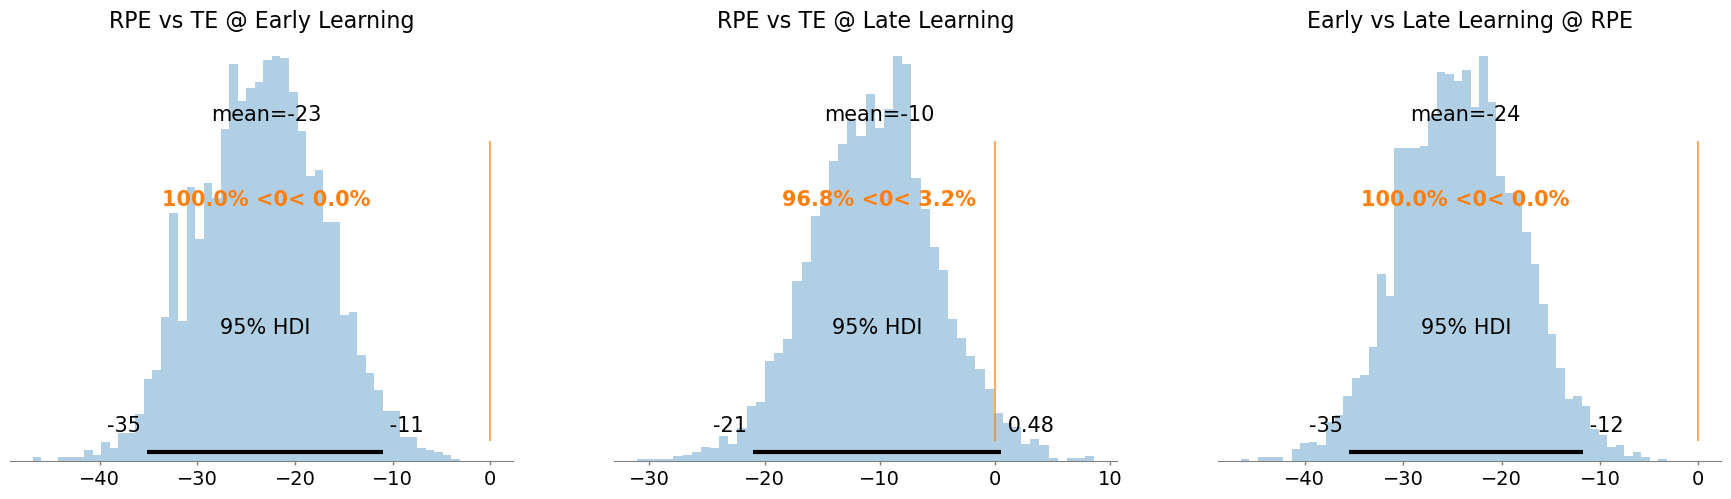

In [491]:
# Convert coefficients to sum-to-zero deflections
post_success_e1 = bst.two_factor_anova_convert_to_sum_to_zero(idata_success_e1, e1_error_lrn.group, e1_error_lrn.time)
# Rename the dimensions for easier label-based indexing
post_success_e1 = post_success_e1.rename({"factor1": "group", "factor2": "time"})

# #Main effect constrasts
# contrasts = {"RPE vs TE": post_success_e1.b1.sel(group='RPE') - post_success_e1.b1.sel(group='TE'),
#             "Early vs Late": post_success_e1.b2.sel(time='Early') - post_success_e1.b2.sel(time='Late')}
# az.plot_posterior(contrasts, 
#                   kind="hist", 
#                   bins=50, 
#                   round_to=2,
#                   point_estimate="mean", 
#                   ref_val=0,
#                   hdi_prob=0.95);

interaction_contrasts = {"RPE vs TE @ Early Learning": post_success_e1.m.sel(group="RPE", time="Early") - post_success_e1.m.sel(group="TE", time="Early"),
                        "RPE vs TE @ Late Learning": post_success_e1.m.sel(group="RPE", time="Late") - post_success_e1.m.sel(group="TE", time="Late"),
                        "Early vs Late Learning @ RPE": post_success_e1.m.sel(group="RPE", time="Early") - post_success_e1.m.sel(group="RPE", time="Late")}

az.plot_posterior(interaction_contrasts, 
                  kind="hist",
                  bins=50,
                  point_estimate="mean", 
                  round_to=2,
                  ref_val=0,
                  hdi_prob=0.95);

In [492]:
# rpe_early_hdi = az.hdi(post_success_e1.m.sel(group="RPE", time="Early").values, hdi_prob=0.95)
rpe_late_hdi = az.hdi(post_success_e1.m.sel(group="RPE", time="Late").values, hdi_prob=0.95)
te_early_hdi = az.hdi(post_success_e1.m.sel(group="TE", time="Early").values, hdi_prob=0.95)
te_late_hdi = az.hdi(post_success_e1.m.sel(group="TE", time="Late").values, hdi_prob=0.95)

print('RPE Percent Success during Early learning =', np.round(np.mean(post_success_e1.m.sel(group="RPE", time="Early").values),1), np.round(rpe_early_hdi,1))
print('RPE Percent Success during Late learning =', np.round(np.mean(post_success_e1.m.sel(group="RPE", time="Late").values),1), np.round(rpe_late_hdi,1))

print('TE Percent Success during Early learning =', np.round(np.mean(post_success_e1.m.sel(group="TE", time="Early").values),1), np.round(te_early_hdi,1))
print('TE Percent Success during Late learning =', np.round(np.mean(post_success_e1.m.sel(group="TE", time="Late").values),1), np.round(te_late_hdi,1))

RPE Percent Success during Early learning = 52.0 [2.6 4.5]
RPE Percent Success during Late learning = 75.7 [67.6 83.6]
TE Percent Success during Early learning = 74.9 [66.5 82.7]
TE Percent Success during Late learning = 85.7 [77.9 93.7]


## Learning variability

In [340]:

model_var_e1, idata_var_e1 = bayesian_two_factor_anova_robust(df1_var.group, df1_var.time, df1_var.variability, n_draws=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0_tilde, sigma_a1, a1_tilde, sigma_a2, a2_tilde, sigma_a1a2, a1a2_tilde, sigma_y_sd, sigma_y_mode, sigma, nu_minus1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 291 seconds.


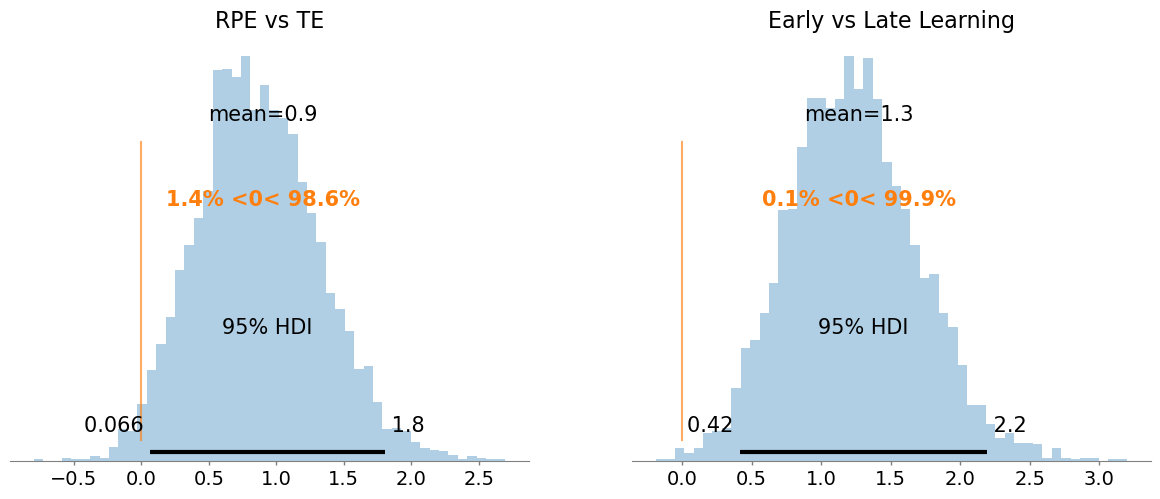

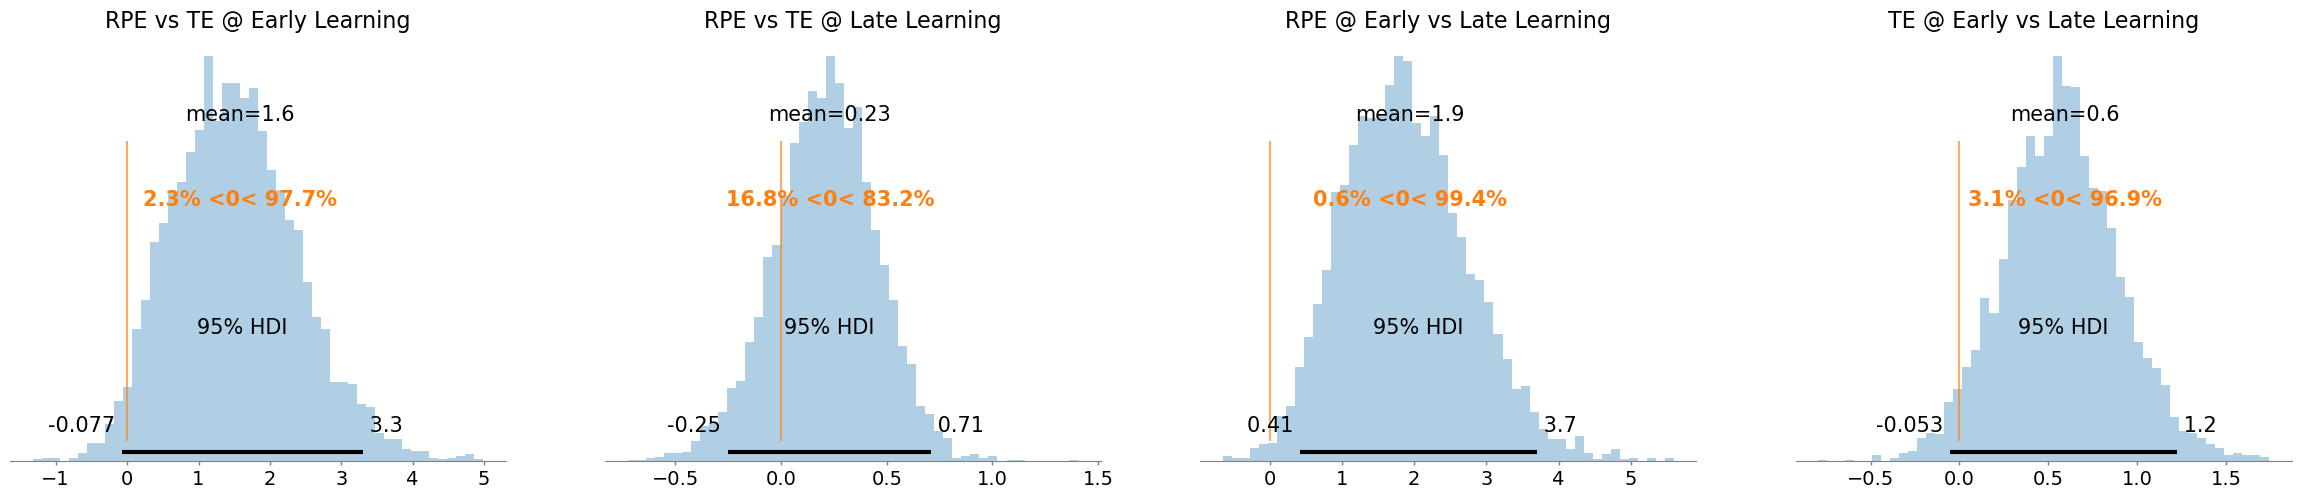

In [572]:
# Convert coefficients to sum-to-zero deflections
post_var_e1 = bst.two_factor_anova_convert_to_sum_to_zero(idata_var_e1, df1_var.group, df1_var.time)
# Rename the dimensions for easier label-based indexing
post_var_e1 = post_var_e1.rename({"factor1": "group", "factor2": "time"})

#Main effect constrasts
contrasts = {"RPE vs TE": post_var_e1.b1.sel(group='RPE') - post_var_e1.b1.sel(group='TE'),
            "Early vs Late Learning": post_var_e1.b2.sel(time='Early') - post_var_e1.b2.sel(time='Late')}
az.plot_posterior(contrasts, 
                  kind="hist", 
                  bins=50, 
                  point_estimate="mean", 
                  ref_val=0,
                  hdi_prob=0.95);

interaction_contrasts = {"RPE vs TE @ Early Learning": post_var_e1.m.sel(group="RPE", time="Early") - post_var_e1.m.sel(group="TE", time="Early"),
                        "RPE vs TE @ Late Learning": post_var_e1.m.sel(group="RPE", time="Late") - post_var_e1.m.sel(group="TE", time="Late"),
                        "RPE @ Early vs Late Learning": post_var_e1.m.sel(group="RPE", time="Early") - post_var_e1.m.sel(group="RPE", time="Late"),
                        "TE @ Early vs Late Learning": post_var_e1.m.sel(group="TE", time="Early") - post_var_e1.m.sel(group="TE", time="Late")}
az.plot_posterior(interaction_contrasts, 
                  kind="hist",
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  hdi_prob=0.95);

In [405]:
rpe_early_hdi = az.hdi(post_var_e1.m.sel(group="RPE", time="Early").values, hdi_prob=0.95)
rpe_late_hdi = az.hdi(post_var_e1.m.sel(group="RPE", time="Late").values, hdi_prob=0.95)

te_early_hdi = az.hdi(post_var_e1.m.sel(group="TE", time="Early").values, hdi_prob=0.95)
te_late_hdi = az.hdi(post_var_e1.m.sel(group="TE", time="Late").values, hdi_prob=0.95)

print('RPE Variability during Early learning =', np.round(np.mean(post_var_e1.m.sel(group="RPE", time="Early").values),3), np.round(rpe_early_hdi,3))
print('RPE Variability during Late learning =', np.round(np.mean(post_var_e1.m.sel(group="RPE", time="Late").values),3), np.round(rpe_late_hdi,3))

print('TE Variability during Early learning =', np.round(np.mean(post_var_e1.m.sel(group="TE", time="Early").values),3), np.round(te_early_hdi,3))
print('TE Variability during Late learning =', np.round(np.mean(post_var_e1.m.sel(group="TE", time="Late").values),3), np.round(te_late_hdi,3))

RPE Variability during Early learning = 4.247 [2.696 5.926]
RPE Variability during Late learning = 2.306 [1.957 2.657]
TE Variability during Early learning = 2.671 [2.09  3.228]
TE Variability during Late learning = 2.074 [1.748 2.41 ]


### Baseline variability

In [348]:
#Run the model
model_bslvar_e1, idata_bslvar_e1 = bst.BEST(df1_var.bsl_var[df1_var.time=="Early"], df1_var.group[df1_var.time=="Early"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_mean, group_std, nu_minus_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


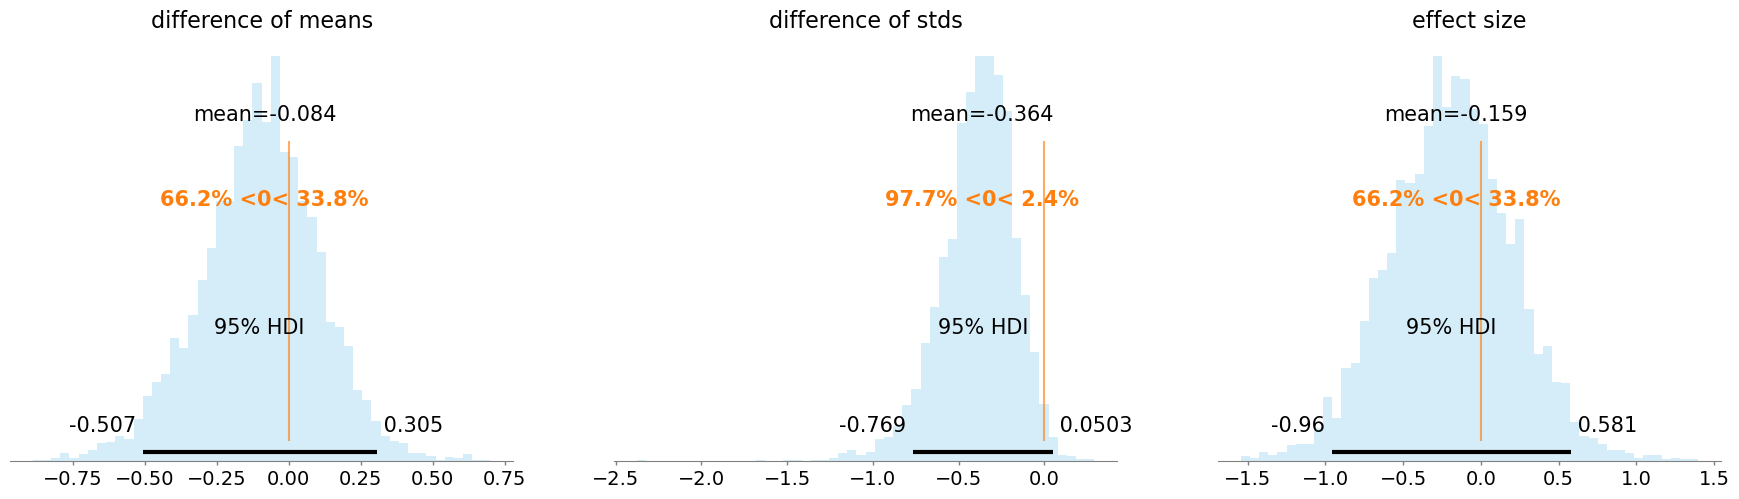

In [351]:
az.plot_posterior(
    idata_bslvar_e1,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
    kind="hist",
    round_to=3,
    bins=50,
    hdi_prob=0.95,
);

In [353]:
e1_bslvar_summary = az.summary(idata_bslvar_e1,hdi_prob=0.95)

print('RPE Baseline Variability =', e1_bslvar_summary['mean'][0], '[', e1_bslvar_summary['hdi_2.5%'][0], e1_bslvar_summary['hdi_97.5%'][0], ']')
print('TE Baseline Variability =', e1_bslvar_summary['mean'][1], '[', e1_bslvar_summary['hdi_2.5%'][1], e1_bslvar_summary['hdi_97.5%'][1], ']')
print('Difference of means =', e1_bslvar_summary['mean'][7], '[', e1_bslvar_summary['hdi_2.5%'][7], e1_bslvar_summary['hdi_97.5%'][7], ']')

RPE Baseline Variability = 1.672 [ 1.504 1.851 ]
TE Baseline Variability = 1.756 [ 1.392 2.146 ]
Difference of means = -0.084 [ -0.507 0.305 ]


### Win-stay / Lose-shift

In [360]:
model_wsls_e1, idata_wsls_e1 = bayesian_two_factor_anova_robust(df1_var.group, df1_var.time, df1_var.wsls, n_draws=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0_tilde, sigma_a1, a1_tilde, sigma_a2, a2_tilde, sigma_a1a2, a1a2_tilde, sigma_y_sd, sigma_y_mode, sigma, nu_minus1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 201 seconds.


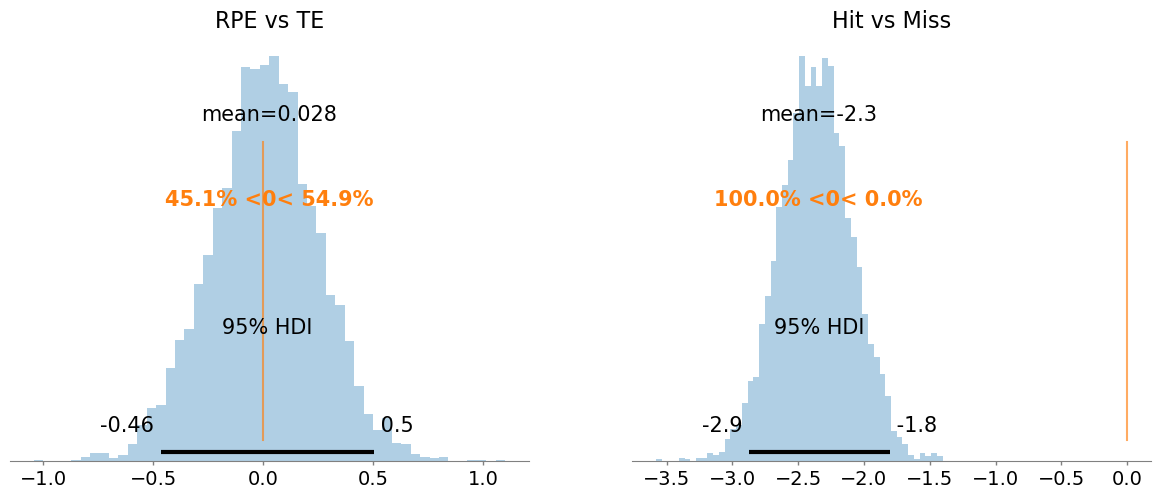

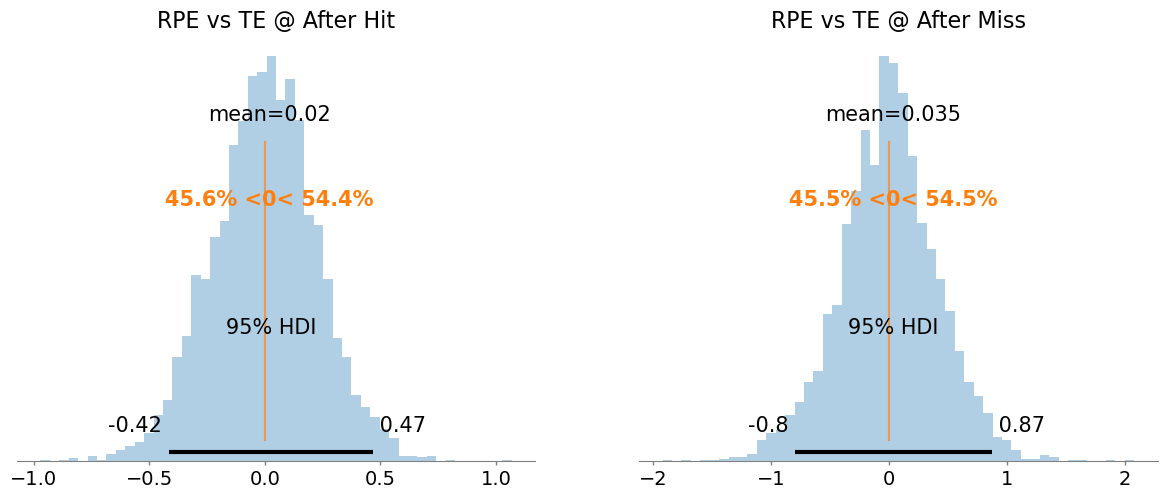

In [407]:
# Convert coefficients to sum-to-zero deflections
post_wsls_e1 = bst.two_factor_anova_convert_to_sum_to_zero(idata_wsls_e1, df1_var.group, df1_var.time)
# Rename the dimensions for easier label-based indexing
post_wsls_e1 = post_wsls_e1.rename({"factor1": "group", "factor2": "time"})

#Main effect constrasts
contrasts = {"RPE vs TE": post_wsls_e1.b1.sel(group='RPE') - post_wsls_e1.b1.sel(group='TE'),
            "Hit vs Miss": post_wsls_e1.b2.sel(time='Early') - post_wsls_e1.b2.sel(time='Late')}
az.plot_posterior(contrasts, 
                  kind="hist", 
                  bins=50, 
                  point_estimate="mean", 
                  ref_val=0,
                  hdi_prob=0.95);

interaction_contrasts = {"RPE vs TE @ After Hit": post_wsls_e1.m.sel(group="RPE", time="Early") - post_wsls_e1.m.sel(group="TE", time="Early"),
            "RPE vs TE @ After Miss": post_wsls_e1.m.sel(group="RPE", time="Late") - post_wsls_e1.m.sel(group="TE", time="Late")}
az.plot_posterior(interaction_contrasts, 
                  kind="hist",
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  hdi_prob=0.95);

In [366]:
rpe_early_hdi = az.hdi(post_wsls_e1.m.sel(group="RPE", time="Early").values, hdi_prob=0.95)
rpe_late_hdi = az.hdi(post_wsls_e1.m.sel(group="RPE", time="Late").values, hdi_prob=0.95)

te_early_hdi = az.hdi(post_wsls_e1.m.sel(group="TE", time="Early").values, hdi_prob=0.95)
te_late_hdi = az.hdi(post_wsls_e1.m.sel(group="TE", time="Late").values, hdi_prob=0.95)

print('RPE Change After Hit =', np.round(np.mean(post_wsls_e1.m.sel(group="RPE", time="Early").values),3), np.round(rpe_early_hdi,3))
print('RPE Change After Miss =', np.round(np.mean(post_wsls_e1.m.sel(group="RPE", time="Late").values),3), np.round(rpe_late_hdi,3))

print('TE Change After Hit =', np.round(np.mean(post_wsls_e1.m.sel(group="TE", time="Early").values),3), np.round(te_early_hdi,3))
print('TE Change After Miss =', np.round(np.mean(post_wsls_e1.m.sel(group="TE", time="Late").values),3), np.round(te_late_hdi,3))

RPE Change After Hit = 2.093 [1.83  2.371]
RPE Change After Miss = 4.445 [3.723 5.176]
TE Change After Hit = 2.073 [1.733 2.451]
TE Change After Miss = 4.411 [3.83  4.941]


### Correction trend

In [357]:
#Run the model
model_exp_e1, idata_exp_e1 = bst.BEST(df1_var.slope[df1_var.time=="Early"], df1_var.group[df1_var.time=="Early"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_mean, group_std, nu_minus_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


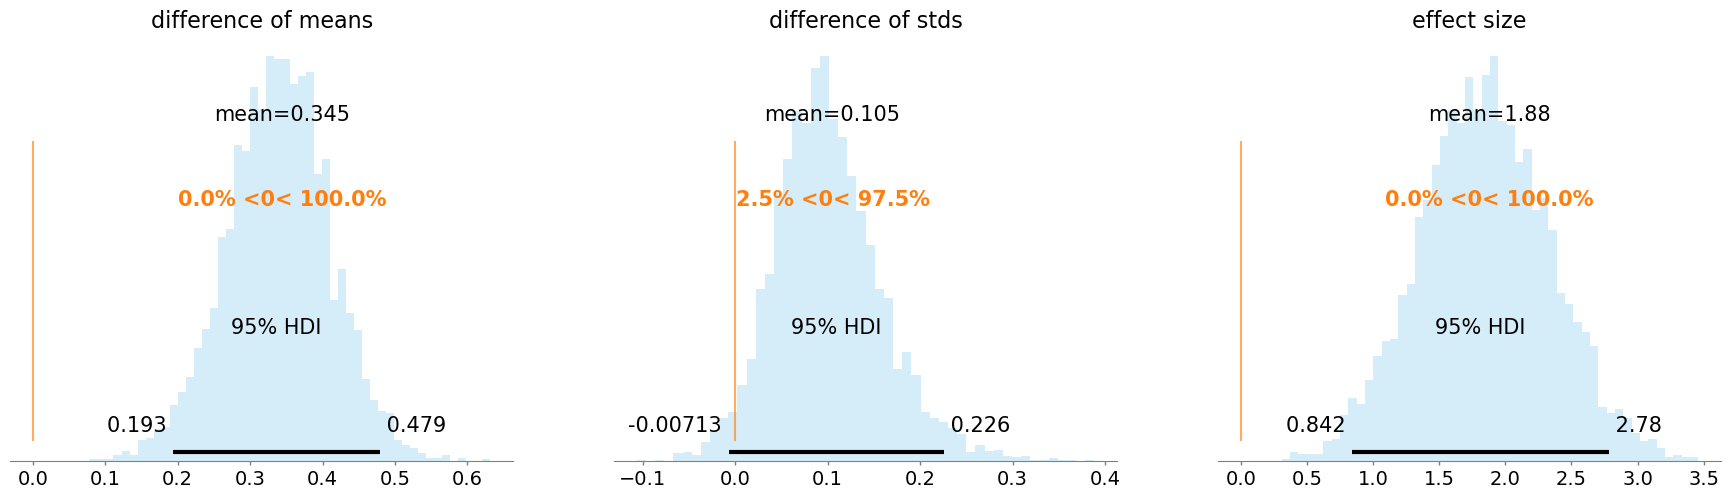

In [358]:
az.plot_posterior(
    idata_exp_e1,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
    kind="hist",
    round_to=3,
    bins=50,
    hdi_prob=0.95,
);

In [359]:
e1_exp_summary = az.summary(idata_exp_e1,hdi_prob=0.95)

print('RPE Correction Trend =', e1_exp_summary['mean'][0], '[', e1_exp_summary['hdi_2.5%'][0], e1_exp_summary['hdi_97.5%'][0], ']')
print('TE Correction Trend =', e1_exp_summary['mean'][1], '[', e1_exp_summary['hdi_2.5%'][1], e1_exp_summary['hdi_97.5%'][1], ']')
print('Difference of means =', e1_exp_summary['mean'][7], '[', e1_exp_summary['hdi_2.5%'][7], e1_exp_summary['hdi_97.5%'][7], ']')

RPE Correction Trend = 0.419 [ 0.303 0.546 ]
TE Correction Trend = 0.075 [ 0.005 0.141 ]
Difference of means = 0.345 [ 0.193 0.479 ]


## Washout difference

In [335]:

model_wsh_e1, idata_wsh_e1 = bayesian_two_factor_anova_robust(df1.group, df1.time, df1.washout, n_draws=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0_tilde, sigma_a1, a1_tilde, sigma_a2, a2_tilde, sigma_a1a2, a1a2_tilde, sigma_y_sd, sigma_y_mode, sigma, nu_minus1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 592 seconds.


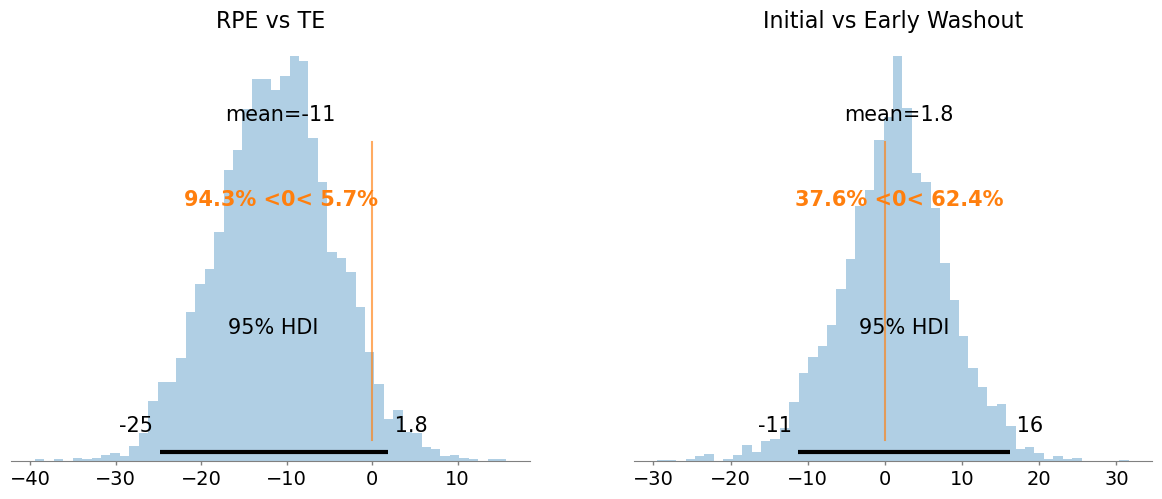

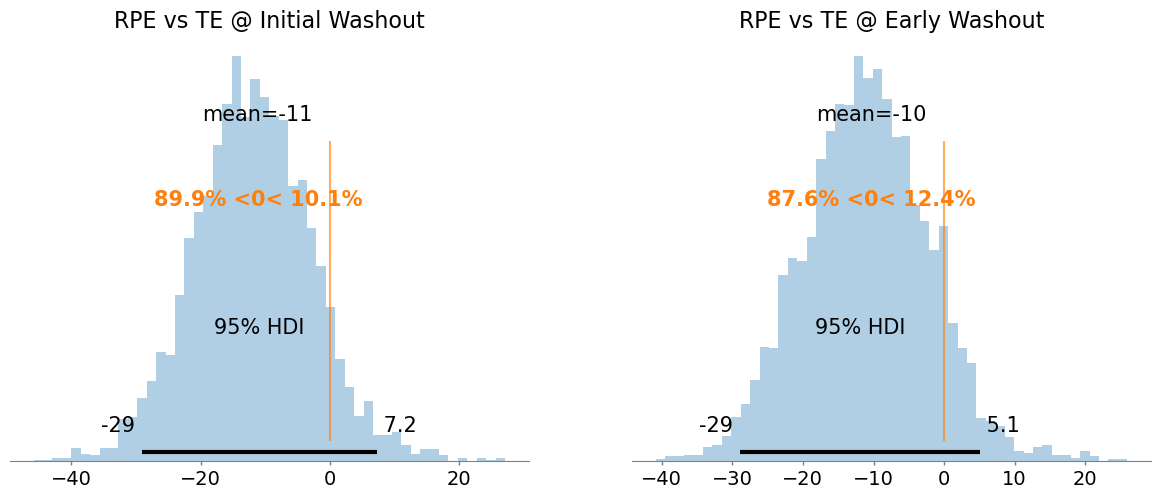

In [336]:
# Convert coefficients to sum-to-zero deflections
post_wsh_e1 = bst.two_factor_anova_convert_to_sum_to_zero(idata_wsh_e1, df1.group, df1.time)
# Rename the dimensions for easier label-based indexing
post_wsh_e1 = post_wsh_e1.rename({"factor1": "group", "factor2": "time"})

#Main effect constrasts
contrasts = {"RPE vs TE": post_wsh_e1.b1.sel(group='RPE') - post_wsh_e1.b1.sel(group='TE'),
            "Initial vs Early Washout": post_wsh_e1.b2.sel(time='Early') - post_wsh_e1.b2.sel(time='Late')}
az.plot_posterior(contrasts, 
                  kind="hist", 
                  bins=50, 
                  point_estimate="mean", 
                  ref_val=0,
                  hdi_prob=0.95);

interaction_contrasts = {"RPE vs TE @ Initial Washout": post_wsh_e1.m.sel(group="RPE", time="Early") - post_wsh_e1.m.sel(group="TE", time="Early"),
            "RPE vs TE @ Early Washout": post_wsh_e1.m.sel(group="RPE", time="Late") - post_wsh_e1.m.sel(group="TE", time="Late")}
az.plot_posterior(interaction_contrasts, 
                  kind="hist",
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  hdi_prob=0.95);

In [408]:
rpe_iwsh_hdi = az.hdi(post_wsh_e1.m.sel(group="RPE", time="Early").values, hdi_prob=0.95)
rpe_ewsh_hdi = az.hdi(post_wsh_e1.m.sel(group="RPE", time="Late").values, hdi_prob=0.95)
te_iwsh_hdi = az.hdi(post_wsh_e1.m.sel(group="TE", time="Early").values, hdi_prob=0.95)
te_ewsh_hdi = az.hdi(post_wsh_e1.m.sel(group="TE", time="Late").values, hdi_prob=0.95)

print('RPE Retention Percent during Initial Washout =', np.round(np.mean(post_wsh_e1.m.sel(group="RPE", time="Early").values),3), np.round(rpe_iwsh_hdi,3))
print('RPE Retention Percent during Early Washout =', np.round(np.mean(post_wsh_e1.m.sel(group="RPE", time="Late").values),3), np.round(rpe_ewsh_hdi,3))

print('TE Retention Percent during Initial Washout =', np.round(np.mean(post_wsh_e1.m.sel(group="TE", time="Early").values),3), np.round(te_iwsh_hdi,3))
print('TE Retention Percent during Early Washout =', np.round(np.mean(post_wsh_e1.m.sel(group="TE", time="Late").values),3), np.round(te_ewsh_hdi,3))

RPE Retention Percent during Initial Washout = 22.224 [ 8.159 36.212]
RPE Retention Percent during Early Washout = 20.85 [ 6.899 33.782]
TE Retention Percent during Initial Washout = 33.401 [19.779 46.007]
TE Retention Percent during Early Washout = 31.126 [19.249 42.942]


### Washout regression

In [567]:
X = df1_reg[["success", "variability", "group"]]
y = df1_reg["Iwsh"]
model_wsh_regress, idata_wsh_regress = bst.multiple_linear_regression(X, y, n_draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zbeta0, zbeta, nu_minus_one, nu, zsigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


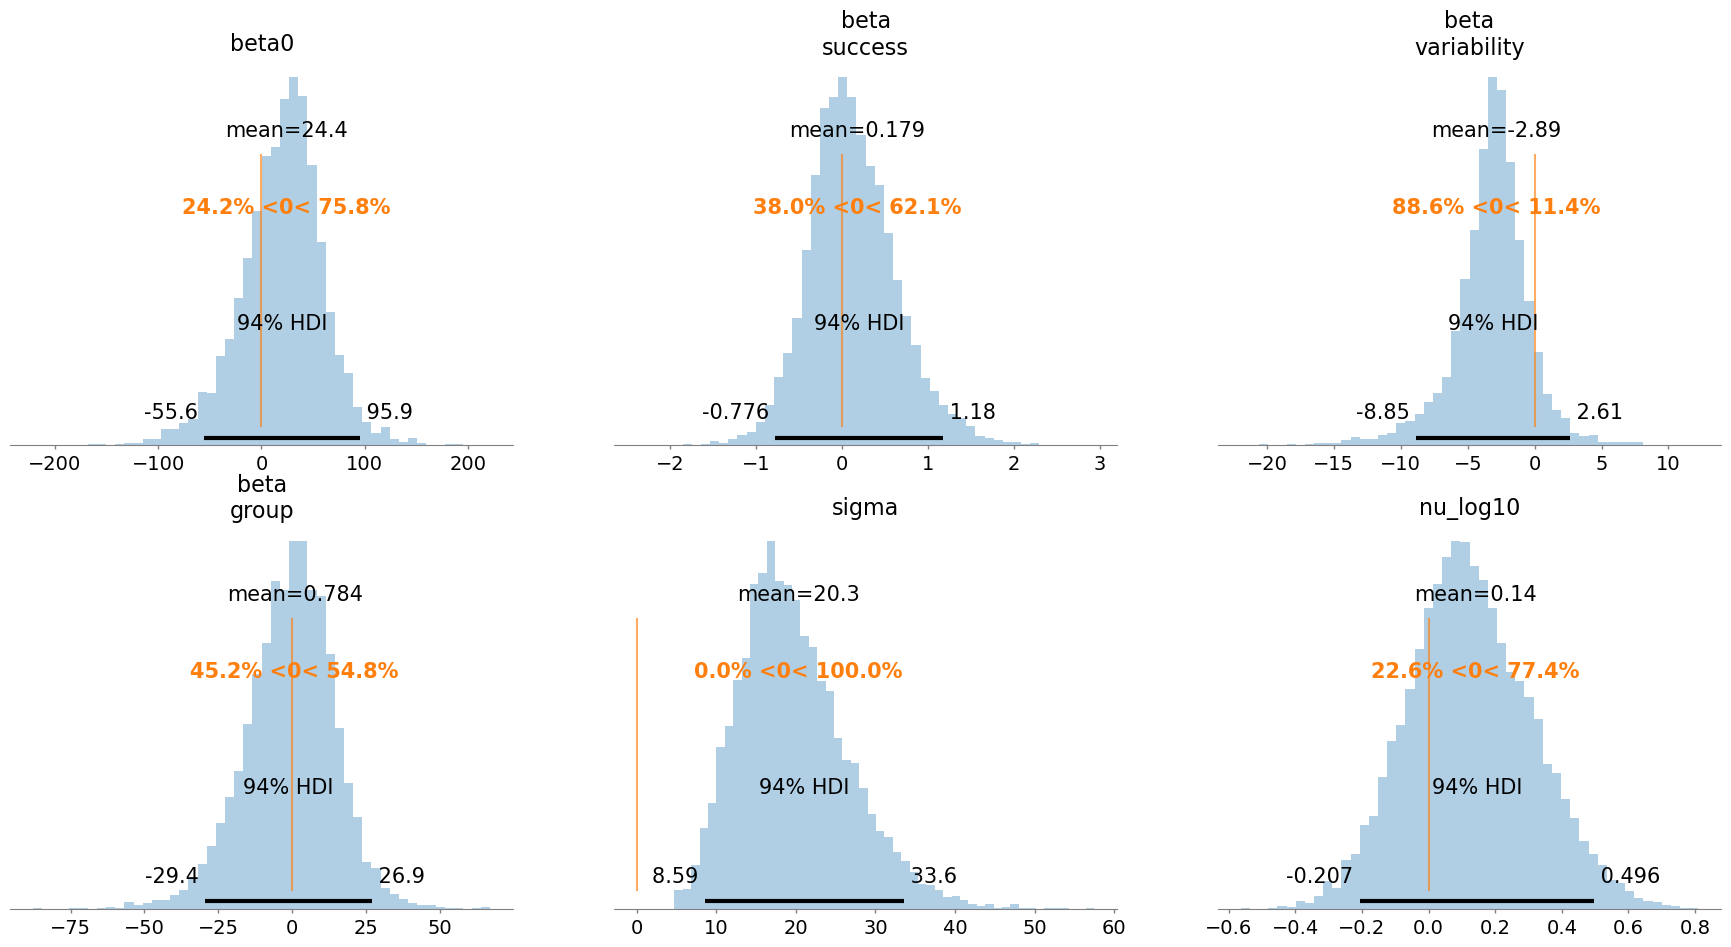

In [569]:
post_wsh_regress = az.extract(idata_wsh_regress.posterior)
# Return parameters to raw data scale
post_wsh_regress["beta0"], post_wsh_regress["beta"], post_wsh_regress["sigma"] = bst.unstandardize_multiple_linreg_parameters(
    post_wsh_regress["zbeta0"], post_wsh_regress["zbeta"], post_wsh_regress["zsigma"], X, y)

# Note that we have to pass "sample" to the combine_dims argument since we stacked our chains
az.plot_posterior(
    post_wsh_regress,
    var_names=["beta0", "beta", "sigma", "nu_log10"],
    combine_dims={"sample"},
    point_estimate="mean",
    round_to=3,
    ref_val=0,
    kind="hist",
    bins=50
);

# Experiment 2

## End of learning differences

In [371]:
#Run the model
model_lrn_e2, idata_lrn_e2 = bst.BEST(df2.late_lrn[df2.time=="Early"], df2.group[df2.time=="Early"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_mean, group_std, nu_minus_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


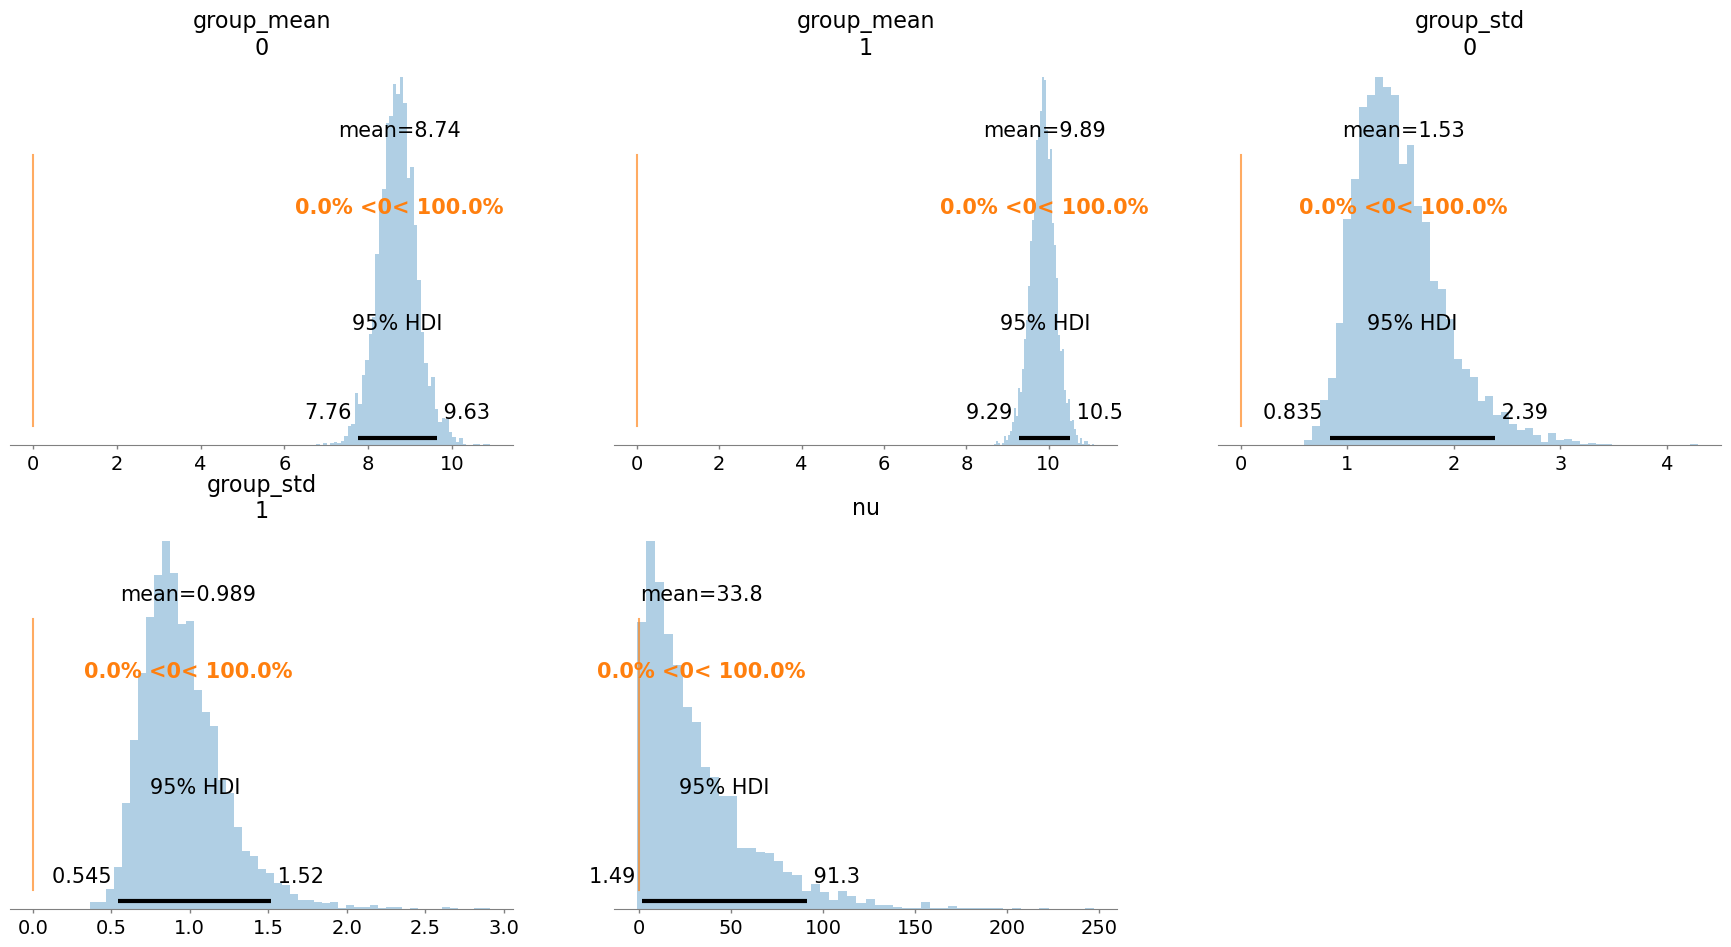

In [372]:
az.plot_posterior(
    idata_lrn_e2,
    var_names=["group_mean", "group_std", "nu"],
    kind="hist",
    round_to=3,
    bins=50,
    hdi_prob=0.95,
    ref_val=0,
);

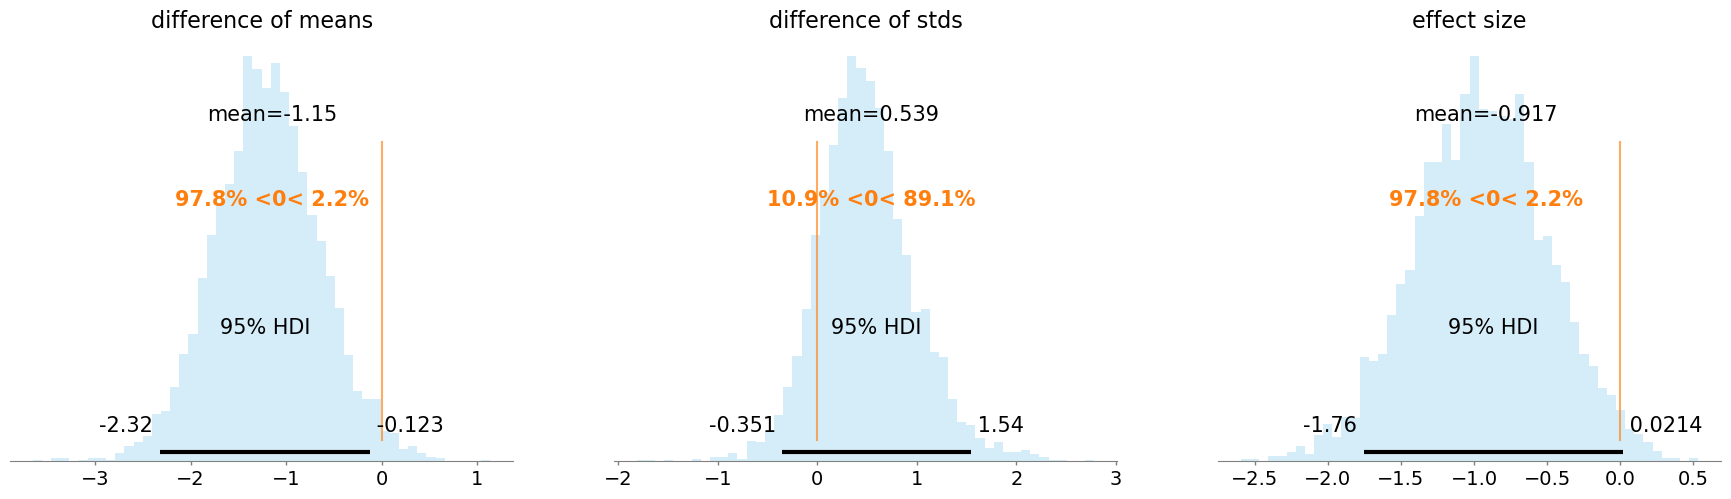

In [374]:
az.plot_posterior(
    idata_lrn_e2,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
    kind="hist",
    round_to=3,
    bins=50,
    hdi_prob=0.95,
);

In [375]:
e2_endlrn_summary = az.summary(idata_lrn_e2,hdi_prob=0.95)

print('RPE Total Learning =', e2_endlrn_summary['mean'][0], '[', e2_endlrn_summary['hdi_2.5%'][0], e2_endlrn_summary['hdi_97.5%'][0], ']')
print('TE Total Learning =', e2_endlrn_summary['mean'][1], '[', e2_endlrn_summary['hdi_2.5%'][1], e2_endlrn_summary['hdi_97.5%'][1], ']')
print('Difference of means =', e2_endlrn_summary['mean'][7], '[', e2_endlrn_summary['hdi_2.5%'][7], e2_endlrn_summary['hdi_97.5%'][7], ']')

RPE Total Learning = 8.739 [ 7.76 9.634 ]
TE Total Learning = 9.886 [ 9.286 10.528 ]
Difference of means = -1.147 [ -2.322 -0.123 ]


## Error Differences

In [378]:
model_err_e2, idata_err_e2 = bayesian_two_factor_anova_robust(df2.group, df2.time, df2.error, n_draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0_tilde, sigma_a1, a1_tilde, sigma_a2, a2_tilde, sigma_a1a2, a1a2_tilde, sigma_y_sd, sigma_y_mode, sigma, nu_minus1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 204 seconds.


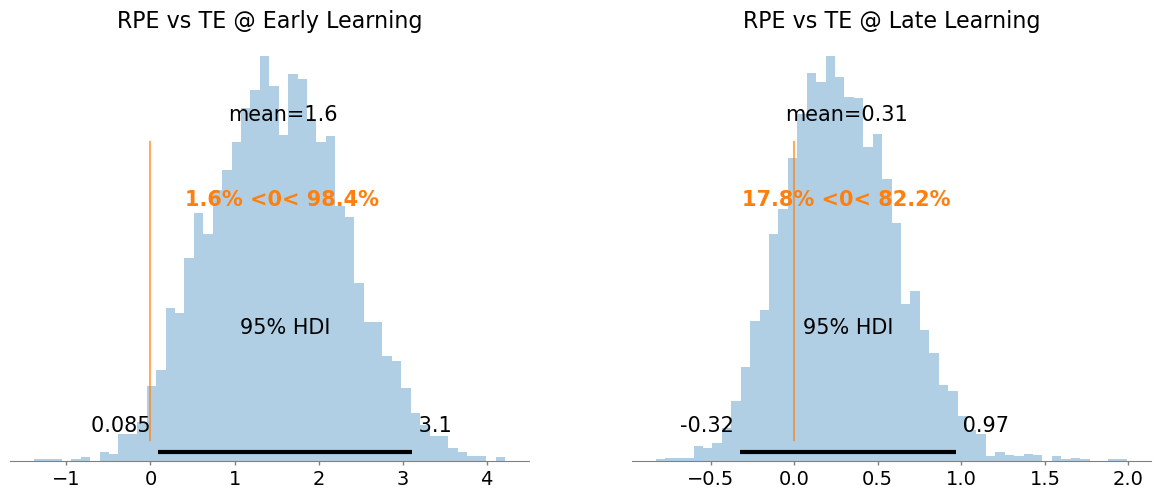

In [379]:
# Convert coefficients to sum-to-zero deflections
post_err_e2 = bst.two_factor_anova_convert_to_sum_to_zero(idata_err_e2, df2.group, df2.time)
# Rename the dimensions for easier label-based indexing
post_err_e2 = post_err_e2.rename({"factor1": "group", "factor2": "time"})

# #Main effect constrasts
# contrasts = {"RPE vs TE": post_err_e2.b1.sel(group='RPE') - post_err_e2.b1.sel(group='TE'),
#             "Early vs Late": post_err_e2.b2.sel(time='Early') - post_err_e2.b2.sel(time='Late')}
# az.plot_posterior(contrasts, 
#                   kind="hist", 
#                   combine_dims={"sample"},
#                   bins=50, 
#                   point_estimate="mean", 
#                   ref_val=0,
#                   hdi_prob=0.95);

interaction_contrasts = {"RPE vs TE @ Early Learning": post_err_e2.m.sel(group="RPE", time="Early") - post_err_e2.m.sel(group="TE", time="Early"),
            "RPE vs TE @ Late Learning": post_err_e2.m.sel(group="RPE", time="Late") - post_err_e2.m.sel(group="TE", time="Late")}
az.plot_posterior(interaction_contrasts, 
                  kind="hist",
                  combine_dims={"sample"},
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  hdi_prob=0.95);

In [380]:
rpe_early_hdi = az.hdi(post_err_e2.m.sel(group="RPE", time="Early").values, hdi_prob=0.95)
rpe_late_hdi = az.hdi(post_err_e2.m.sel(group="RPE", time="Late").values, hdi_prob=0.95)

te_early_hdi = az.hdi(post_err_e2.m.sel(group="TE", time="Early").values, hdi_prob=0.95)
te_late_hdi = az.hdi(post_err_e2.m.sel(group="TE", time="Late").values, hdi_prob=0.95)

print('RPE Error during Early learning =', np.round(np.mean(post_err_e2.m.sel(group="RPE", time="Early").values),3), np.round(rpe_early_hdi,3))
print('RPE Error during Late learning =', np.round(np.mean(post_err_e2.m.sel(group="RPE", time="Late").values),3), np.round(rpe_late_hdi,3))

print('TE Error during Early learning =', np.round(np.mean(post_err_e2.m.sel(group="TE", time="Early").values),3), np.round(te_early_hdi,3))
print('TE Error during Late learning =', np.round(np.mean(post_err_e2.m.sel(group="TE", time="Late").values),3), np.round(te_late_hdi,3))

RPE Error during Early learning = 3.985 [2.635 5.51 ]
RPE Error during Late learning = 2.206 [1.696 2.807]
TE Error during Early learning = 2.417 [2.007 2.872]
TE Error during Late learning = 1.893 [1.61  2.229]


## Percent success differnces

In [381]:
model_success_e2, idata_success_e2 = bayesian_two_factor_anova_robust(df2.group, df2.time, df2.success, n_draws=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0_tilde, sigma_a1, a1_tilde, sigma_a2, a2_tilde, sigma_a1a2, a1a2_tilde, sigma_y_sd, sigma_y_mode, sigma, nu_minus1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 576 seconds.


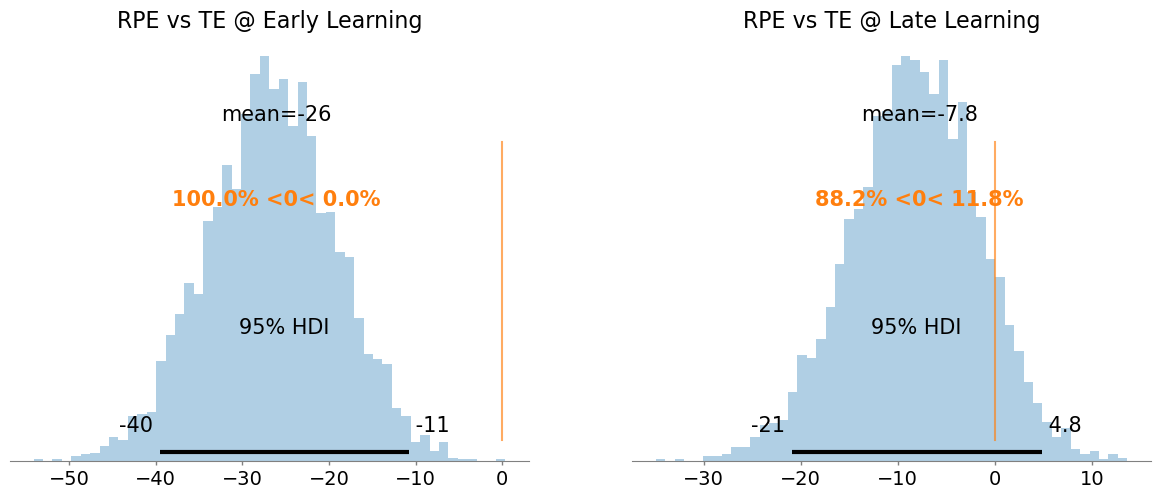

In [385]:
# Convert coefficients to sum-to-zero deflections
post_success_e2 = bst.two_factor_anova_convert_to_sum_to_zero(idata_success_e2, df2.group, df2.time)
# Rename the dimensions for easier label-based indexing
post_success_e2 = post_success_e2.rename({"factor1": "group", "factor2": "time"})

# #Main effect constrasts
# contrasts = {"RPE vs TE": post_success_e1.b1.sel(group='RPE') - post_success_e1.b1.sel(group='TE'),
#             "Early vs Late": post_success_e1.b2.sel(time='Early') - post_success_e1.b2.sel(time='Late')}
# az.plot_posterior(contrasts, 
#                   kind="hist", 
#                   bins=50, 
#                   round_to=2,
#                   point_estimate="mean", 
#                   ref_val=0,
#                   hdi_prob=0.95);

interaction_contrasts = {"RPE vs TE @ Early Learning": post_success_e2.m.sel(group="RPE", time="Early") - post_success_e2.m.sel(group="TE", time="Early"),
            "RPE vs TE @ Late Learning": post_success_e2.m.sel(group="RPE", time="Late") - post_success_e2.m.sel(group="TE", time="Late")}
az.plot_posterior(interaction_contrasts, 
                  kind="hist",
                  bins=50,
                  point_estimate="mean", 
                  round_to=2,
                  ref_val=0,
                  hdi_prob=0.95);

In [386]:
rpe_early_hdi = az.hdi(post_success_e2.m.sel(group="RPE", time="Early").values, hdi_prob=0.95)
rpe_late_hdi = az.hdi(post_success_e2.m.sel(group="RPE", time="Late").values, hdi_prob=0.95)
te_early_hdi = az.hdi(post_success_e2.m.sel(group="TE", time="Early").values, hdi_prob=0.95)
te_late_hdi = az.hdi(post_success_e2.m.sel(group="TE", time="Late").values, hdi_prob=0.95)

print('RPE Percent Success during Early learning =', np.round(np.mean(post_success_e2.m.sel(group="RPE", time="Early").values),1), np.round(rpe_early_hdi,1))
print('RPE Percent Success during Late learning =', np.round(np.mean(post_success_e2.m.sel(group="RPE", time="Late").values),1), np.round(rpe_late_hdi,1))

print('TE Percent Success during Early learning =', np.round(np.mean(post_success_e2.m.sel(group="TE", time="Early").values),1), np.round(te_early_hdi,1))
print('TE Percent Success during Late learning =', np.round(np.mean(post_success_e2.m.sel(group="TE", time="Late").values),1), np.round(te_late_hdi,1))

RPE Percent Success during Early learning = 49.1 [38.4 60.3]
RPE Percent Success during Late learning = 77.4 [67.7 86.5]
TE Percent Success during Early learning = 75.2 [66.7 84.6]
TE Percent Success during Late learning = 85.2 [75.6 93.6]


## Learning variability

In [388]:
model_var_e2, idata_var_e2 = bayesian_two_factor_anova_robust(df2_var.group, df2_var.time, df2_var.variability, n_draws=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0_tilde, sigma_a1, a1_tilde, sigma_a2, a2_tilde, sigma_a1a2, a1a2_tilde, sigma_y_sd, sigma_y_mode, sigma, nu_minus1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 136 seconds.


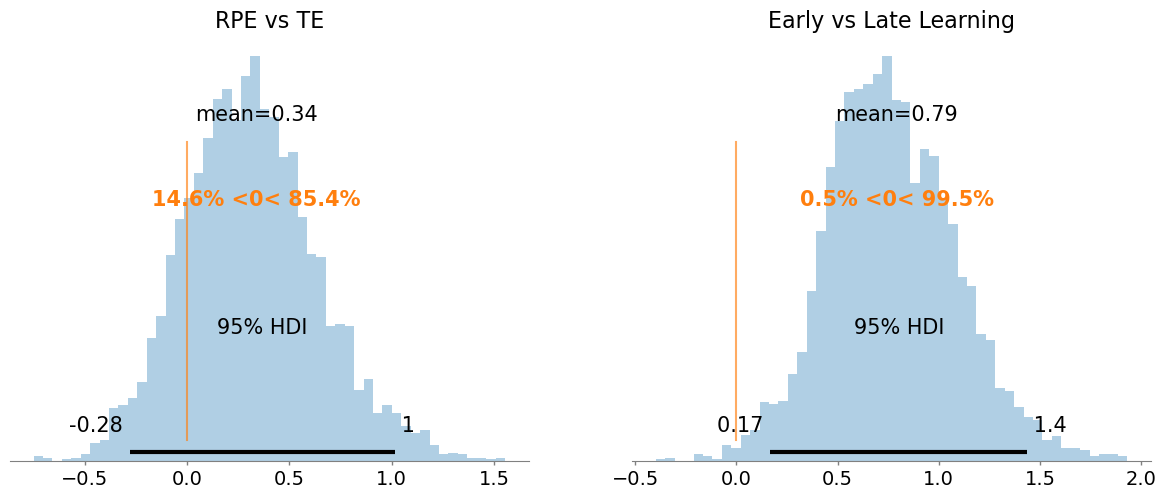

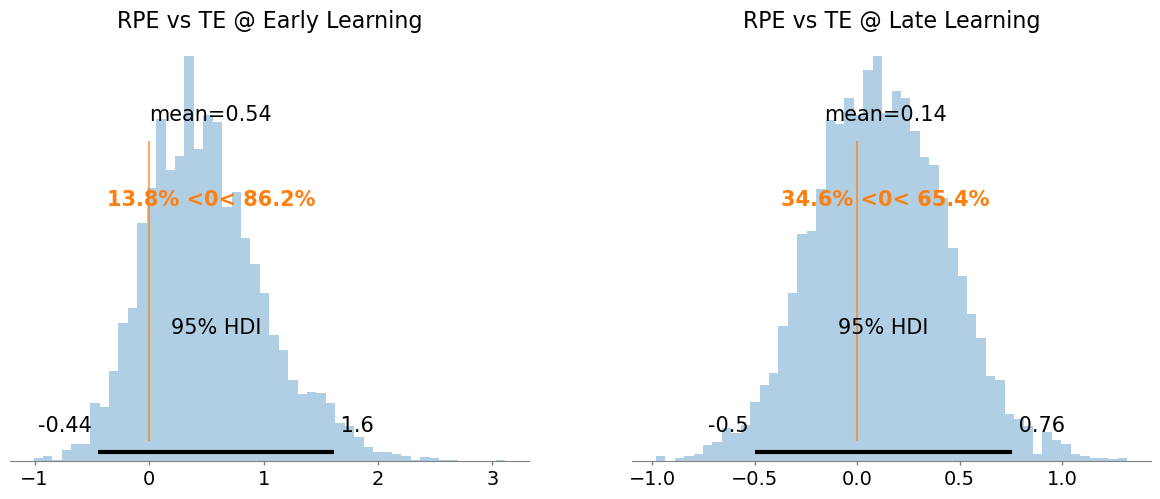

In [389]:
# Convert coefficients to sum-to-zero deflections
post_var_e2 = bst.two_factor_anova_convert_to_sum_to_zero(idata_var_e2, df2_var.group, df2_var.time)
# Rename the dimensions for easier label-based indexing
post_var_e2 = post_var_e2.rename({"factor1": "group", "factor2": "time"})

#Main effect constrasts
contrasts = {"RPE vs TE": post_var_e2.b1.sel(group='RPE') - post_var_e2.b1.sel(group='TE'),
            "Early vs Late Learning": post_var_e2.b2.sel(time='Early') - post_var_e2.b2.sel(time='Late')}
az.plot_posterior(contrasts, 
                  kind="hist", 
                  bins=50, 
                  point_estimate="mean", 
                  ref_val=0,
                  hdi_prob=0.95);

interaction_contrasts = {"RPE vs TE @ Early Learning": post_var_e2.m.sel(group="RPE", time="Early") - post_var_e2.m.sel(group="TE", time="Early"),
            "RPE vs TE @ Late Learning": post_var_e2.m.sel(group="RPE", time="Late") - post_var_e2.m.sel(group="TE", time="Late")}
az.plot_posterior(interaction_contrasts, 
                  kind="hist",
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  hdi_prob=0.95);

In [493]:
rpe_early_hdi = az.hdi(post_var_e2.m.sel(group="RPE", time="Early").values, hdi_prob=0.95)
rpe_late_hdi = az.hdi(post_var_e2.m.sel(group="RPE", time="Late").values, hdi_prob=0.95)

te_early_hdi = az.hdi(post_var_e2.m.sel(group="TE", time="Early").values, hdi_prob=0.95)
te_late_hdi = az.hdi(post_var_e2.m.sel(group="TE", time="Late").values, hdi_prob=0.95)

print('RPE Variability during Early learning =', np.round(np.mean(post_var_e2.m.sel(group="RPE", time="Early").values),1), np.round(rpe_early_hdi,1))
print('RPE Variability during Late learning =', np.round(np.mean(post_var_e2.m.sel(group="RPE", time="Late").values),1), np.round(rpe_late_hdi,1))

print('TE Variability during Early learning =', np.round(np.mean(post_var_e2.m.sel(group="TE", time="Early").values),1), np.round(te_early_hdi,1))
print('TE Variability during Late learning =', np.round(np.mean(post_var_e2.m.sel(group="TE", time="Late").values),1), np.round(te_late_hdi,1))

RPE Variability during Early learning = 3.4 [2.6 4.5]
RPE Variability during Late learning = 2.4 [2.  2.9]
TE Variability during Early learning = 2.9 [2.4 3.4]
TE Variability during Late learning = 2.3 [1.9 2.7]


### Baseline variability

In [390]:
df2_var.head()

bsl_var  variability      wsls     slope         subj_id group   time
0  1.342230     2.794799  1.484284  0.485118  RewardFB_ER_05   RPE  Early
1  1.276896     4.073997  1.724867  0.671623  RewardFB_ER_06   RPE  Early
2  1.397996     3.235517  1.969938  0.061551  RewardFB_ER_10   RPE  Early
3  1.785264     8.774533  3.661800  0.401134  RewardFB_ER_11   RPE  Early
4  1.971475     1.356310  1.608670  0.684905  RewardFB_ER_12   RPE  Early

In [391]:
#Run the model
model_bslvar_e2, idata_bslvar_e2 = bst.BEST(df2_var.bsl_var[df2_var.time=="Early"], df2_var.group[df2_var.time=="Early"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_mean, group_std, nu_minus_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


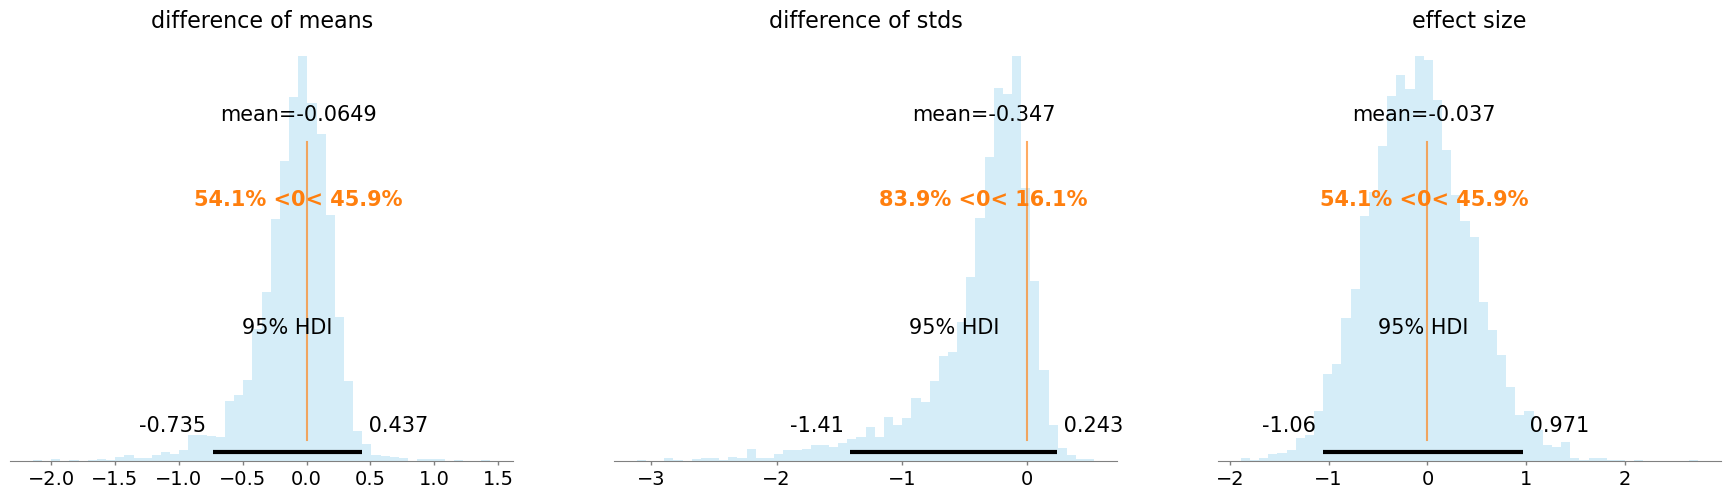

In [392]:
az.plot_posterior(
    idata_bslvar_e2,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
    kind="hist",
    round_to=3,
    bins=50,
    hdi_prob=0.95,
);

In [393]:
e2_bslvar_summary = az.summary(idata_bslvar_e2,hdi_prob=0.95)

print('RPE Baseline Variability =', e2_bslvar_summary['mean'][0], '[', e2_bslvar_summary['hdi_2.5%'][0], e2_bslvar_summary['hdi_97.5%'][0], ']')
print('TE Baseline Variability =', e2_bslvar_summary['mean'][1], '[', e2_bslvar_summary['hdi_2.5%'][1], e2_bslvar_summary['hdi_97.5%'][1], ']')
print('Difference of means =', e2_bslvar_summary['mean'][7], '[', e2_bslvar_summary['hdi_2.5%'][7], e2_bslvar_summary['hdi_97.5%'][7], ']')

RPE Baseline Variability = 1.644 [ 1.416 1.861 ]
TE Baseline Variability = 1.709 [ 1.274 2.323 ]
Difference of means = -0.065 [ -0.735 0.437 ]


### Win-stay / Lose-shift

In [394]:
model_wsls_e2, idata_wsls_e2 = bayesian_two_factor_anova_robust(df2_var.group, df2_var.time, df2_var.wsls, n_draws=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0_tilde, sigma_a1, a1_tilde, sigma_a2, a2_tilde, sigma_a1a2, a1a2_tilde, sigma_y_sd, sigma_y_mode, sigma, nu_minus1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 164 seconds.


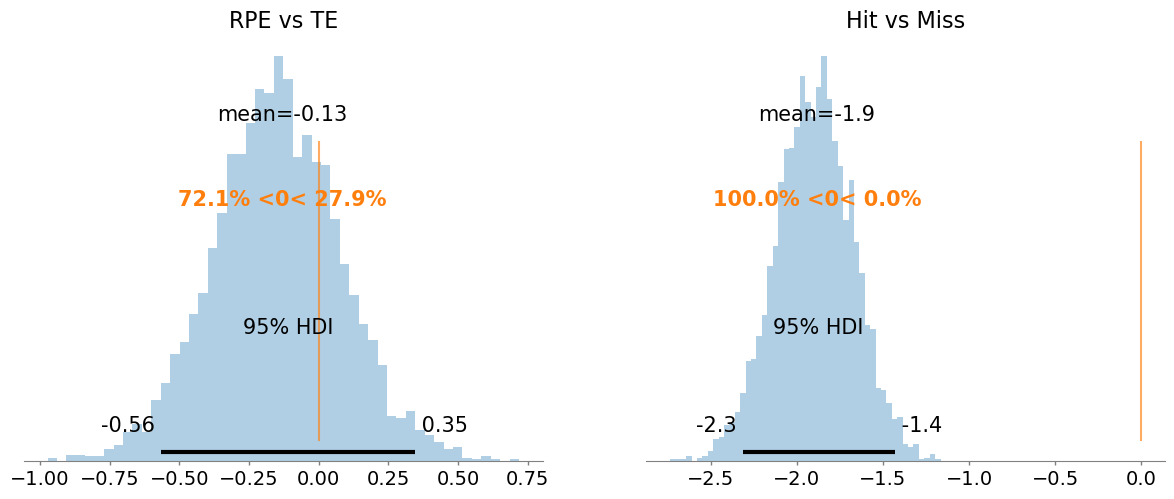

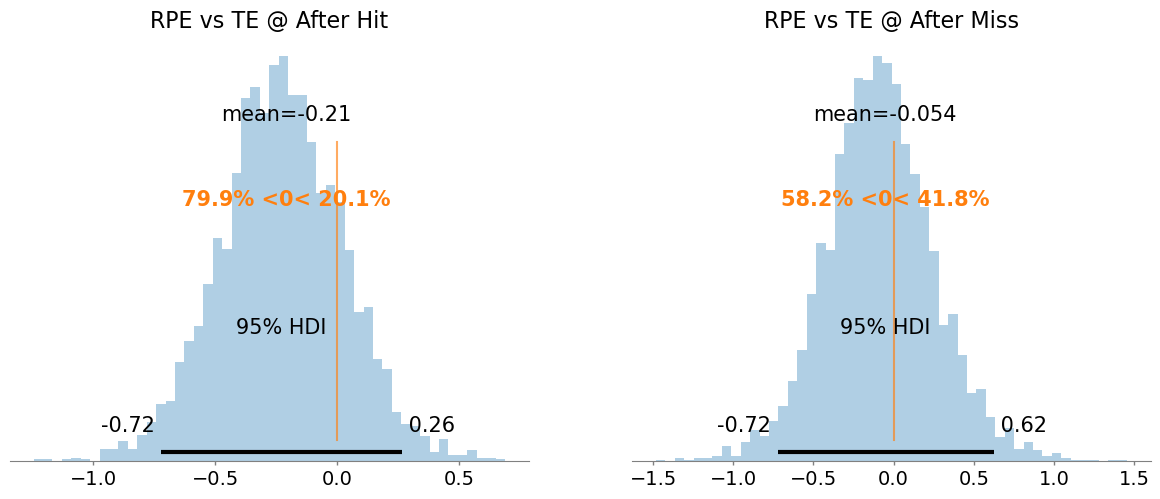

In [395]:
# Convert coefficients to sum-to-zero deflections
post_wsls_e2 = bst.two_factor_anova_convert_to_sum_to_zero(idata_wsls_e2, df2_var.group, df2_var.time)
# Rename the dimensions for easier label-based indexing
post_wsls_e2 = post_wsls_e2.rename({"factor1": "group", "factor2": "time"})

#Main effect constrasts
contrasts = {"RPE vs TE": post_wsls_e2.b1.sel(group='RPE') - post_wsls_e2.b1.sel(group='TE'),
            "Hit vs Miss": post_wsls_e2.b2.sel(time='Early') - post_wsls_e2.b2.sel(time='Late')}
az.plot_posterior(contrasts, 
                  kind="hist", 
                  bins=50, 
                  point_estimate="mean", 
                  ref_val=0,
                  hdi_prob=0.95);

interaction_contrasts = {"RPE vs TE @ After Hit": post_wsls_e2.m.sel(group="RPE", time="Early") - post_wsls_e2.m.sel(group="TE", time="Early"),
            "RPE vs TE @ After Miss": post_wsls_e2.m.sel(group="RPE", time="Late") - post_wsls_e2.m.sel(group="TE", time="Late")}
az.plot_posterior(interaction_contrasts, 
                  kind="hist",
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  hdi_prob=0.95);

In [396]:
rpe_early_hdi = az.hdi(post_wsls_e2.m.sel(group="RPE", time="Early").values, hdi_prob=0.95)
rpe_late_hdi = az.hdi(post_wsls_e2.m.sel(group="RPE", time="Late").values, hdi_prob=0.95)

te_early_hdi = az.hdi(post_wsls_e2.m.sel(group="TE", time="Early").values, hdi_prob=0.95)
te_late_hdi = az.hdi(post_wsls_e2.m.sel(group="TE", time="Late").values, hdi_prob=0.95)

print('RPE Change After Hit =', np.round(np.mean(post_wsls_e2.m.sel(group="RPE", time="Early").values),3), np.round(rpe_early_hdi,3))
print('RPE Change After Miss =', np.round(np.mean(post_wsls_e2.m.sel(group="RPE", time="Late").values),3), np.round(rpe_late_hdi,3))

print('TE Change After Hit =', np.round(np.mean(post_wsls_e2.m.sel(group="TE", time="Early").values),3), np.round(te_early_hdi,3))
print('TE Change After Miss =', np.round(np.mean(post_wsls_e2.m.sel(group="TE", time="Late").values),3), np.round(te_late_hdi,3))

RPE Change After Hit = 2.018 [1.653 2.437]
RPE Change After Miss = 3.979 [3.387 4.572]
TE Change After Hit = 2.228 [1.878 2.549]
TE Change After Miss = 4.034 [3.671 4.392]


### Correction trend

In [397]:
#Run the model
model_exp_e2, idata_exp_e2 = bst.BEST(df2_var.slope[df2_var.time=="Early"], df2_var.group[df2_var.time=="Early"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_mean, group_std, nu_minus_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


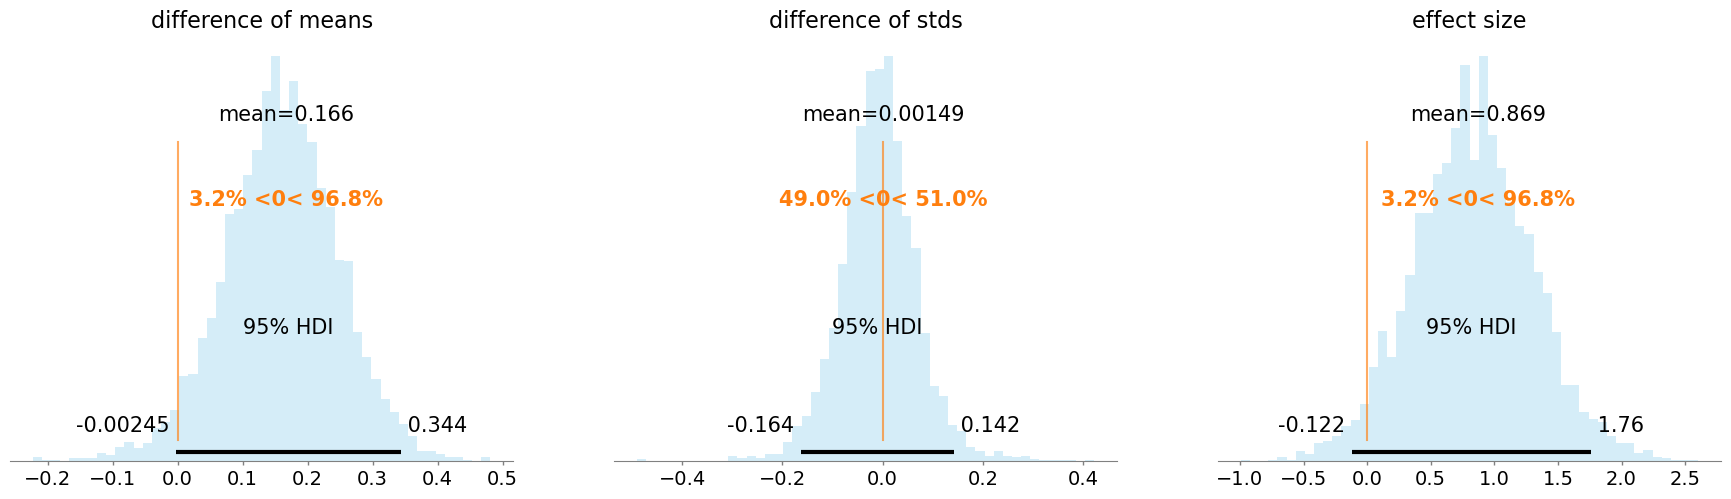

In [398]:
az.plot_posterior(
    idata_exp_e2,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
    kind="hist",
    round_to=3,
    bins=50,
    hdi_prob=0.95,
);

In [399]:
e2_exp_summary = az.summary(idata_exp_e2,hdi_prob=0.95)

print('RPE Correction Trend =', e2_exp_summary['mean'][0], '[', e2_exp_summary['hdi_2.5%'][0], e2_exp_summary['hdi_97.5%'][0], ']')
print('TE Correction Trend =', e2_exp_summary['mean'][1], '[', e2_exp_summary['hdi_2.5%'][1], e2_exp_summary['hdi_97.5%'][1], ']')
print('Difference of means =', e2_exp_summary['mean'][7], '[', e2_exp_summary['hdi_2.5%'][7], e2_exp_summary['hdi_97.5%'][7], ']')

RPE Correction Trend = 0.428 [ 0.299 0.55 ]
TE Correction Trend = 0.261 [ 0.147 0.38 ]
Difference of means = 0.166 [ -0.002 0.344 ]


## Retention

In [401]:
model_ret_e2, idata_ret_e2 = bayesian_two_factor_anova_robust(df2.group, df2.time, df2.ret_prct, n_draws=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0_tilde, sigma_a1, a1_tilde, sigma_a2, a2_tilde, sigma_a1a2, a1a2_tilde, sigma_y_sd, sigma_y_mode, sigma, nu_minus1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 749 seconds.


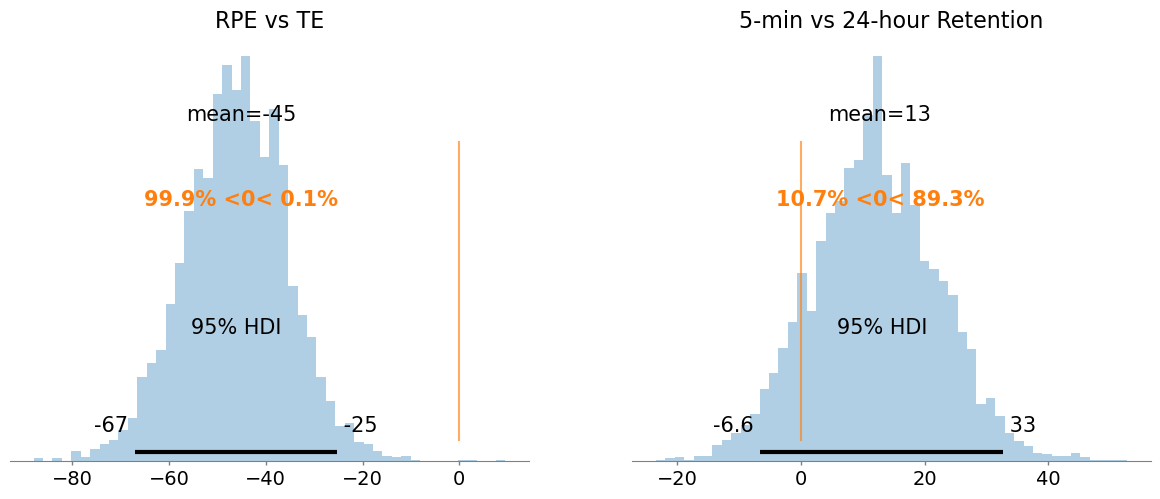

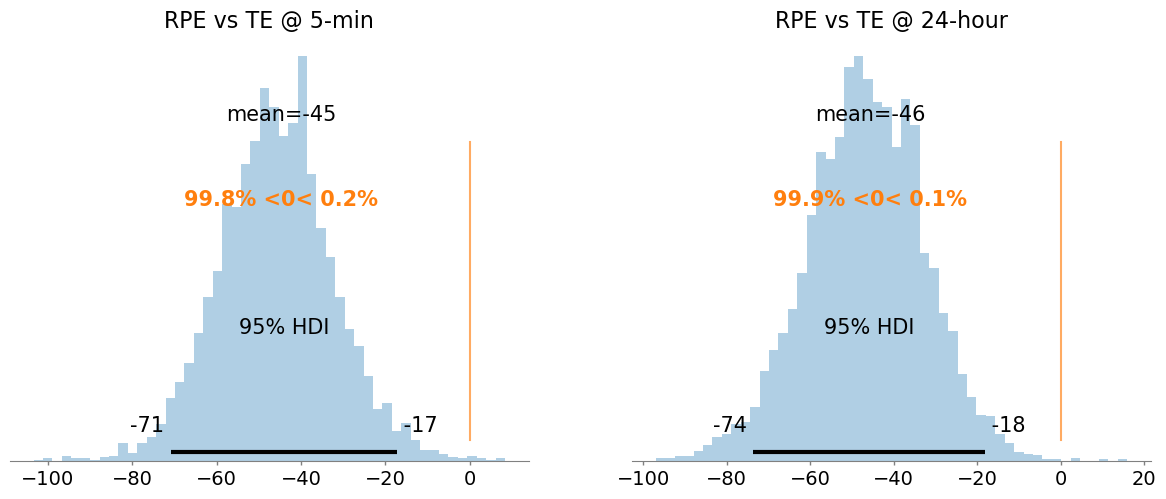

In [402]:
# Convert coefficients to sum-to-zero deflections
post_ret_e2 = bst.two_factor_anova_convert_to_sum_to_zero(idata_ret_e2, df2.group, df2.time)
# Rename the dimensions for easier label-based indexing
post_ret_e2 = post_ret_e2.rename({"factor1": "group", "factor2": "time"})

#Main effect constrasts
contrasts = {"RPE vs TE": post_ret_e2.b1.sel(group='RPE') - post_ret_e2.b1.sel(group='TE'),
            "5-min vs 24-hour Retention": post_ret_e2.b2.sel(time='Early') - post_ret_e2.b2.sel(time='Late')}
az.plot_posterior(contrasts, 
                  kind="hist", 
                  bins=50, 
                  point_estimate="mean", 
                  ref_val=0,
                  hdi_prob=0.95);

interaction_contrasts = {"RPE vs TE @ 5-min": post_ret_e2.m.sel(group="RPE", time="Early") - post_ret_e2.m.sel(group="TE", time="Early"),
            "RPE vs TE @ 24-hour": post_ret_e2.m.sel(group="RPE", time="Late") - post_ret_e2.m.sel(group="TE", time="Late")}
az.plot_posterior(interaction_contrasts, 
                  kind="hist",
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  hdi_prob=0.95);

In [411]:
rpe_iwsh_hdi = az.hdi(post_ret_e2.m.sel(group="RPE", time="Early").values, hdi_prob=0.95)
rpe_ewsh_hdi = az.hdi(post_ret_e2.m.sel(group="RPE", time="Late").values, hdi_prob=0.95)
te_iwsh_hdi = az.hdi(post_ret_e2.m.sel(group="TE", time="Early").values, hdi_prob=0.95)
te_ewsh_hdi = az.hdi(post_ret_e2.m.sel(group="TE", time="Late").values, hdi_prob=0.95)

print('RPE Retention Percent @ 5-min =', np.round(np.mean(post_ret_e2.m.sel(group="RPE", time="Early").values),1), np.round(rpe_iwsh_hdi,1))
print('RPE Retention Percent @ 24-hour =', np.round(np.mean(post_ret_e2.m.sel(group="RPE", time="Late").values),1), np.round(rpe_ewsh_hdi,1))

print('TE Retention Percent @ 5-min =', np.round(np.mean(post_ret_e2.m.sel(group="TE", time="Early").values),1), np.round(te_iwsh_hdi,1))
print('TE Retention Percent @ 24-hour =', np.round(np.mean(post_ret_e2.m.sel(group="TE", time="Late").values),1), np.round(te_ewsh_hdi,1))

RPE Retention Percent @ 5-min = 82.2 [ 62.9 101. ]
RPE Retention Percent @ 24-hour = 69.0 [48.9 88.1]
TE Retention Percent @ 5-min = 126.9 [106.2 146.2]
TE Retention Percent @ 24-hour = 114.5 [ 94.1 135.5]


# Supplemental analysis

In [494]:
df3 = pd.read_csv('supp_stats.txt')
df_th_regress = pd.read_csv('trial_history_regress.txt')
df_th_anova = pd.read_csv('trial_history_anova.txt')

In [495]:
df_th_anova

subj_id  exp group  abs_deltU
0       RewardFB_01    1   RPE   2.582318
1       RewardFB_03    1   RPE   2.447104
2       RewardFB_06    1   RPE   2.438159
3       RewardFB_07    1   RPE   3.570011
4       RewardFB_09    1   RPE   4.543722
..              ...  ...   ...        ...
427  VisualFB_ER_17    2    TE   3.255718
428  VisualFB_ER_20    2    TE   4.711914
429  VisualFB_ER_22    2    TE   5.308693
430  VisualFB_ER_23    2    TE   4.205031
431  VisualFB_ER_25    2    TE   3.692778

[432 rows x 4 columns]

## Trial history Regression

### Exp 1

In [468]:
model_Rhist_e1, idata_Rhist_e1 = bayesian_two_factor_anova_robust(df_trl_hist.group[df_trl_hist.exp==1], 
                                                                  df_trl_hist.R_hist[df_trl_hist.exp==1], 
                                                                  df_trl_hist.betas[df_trl_hist.exp==1], n_draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0_tilde, sigma_a1, a1_tilde, sigma_a2, a2_tilde, sigma_a1a2, a1a2_tilde, sigma_y_sd, sigma_y_mode, sigma, nu_minus1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 337 seconds.


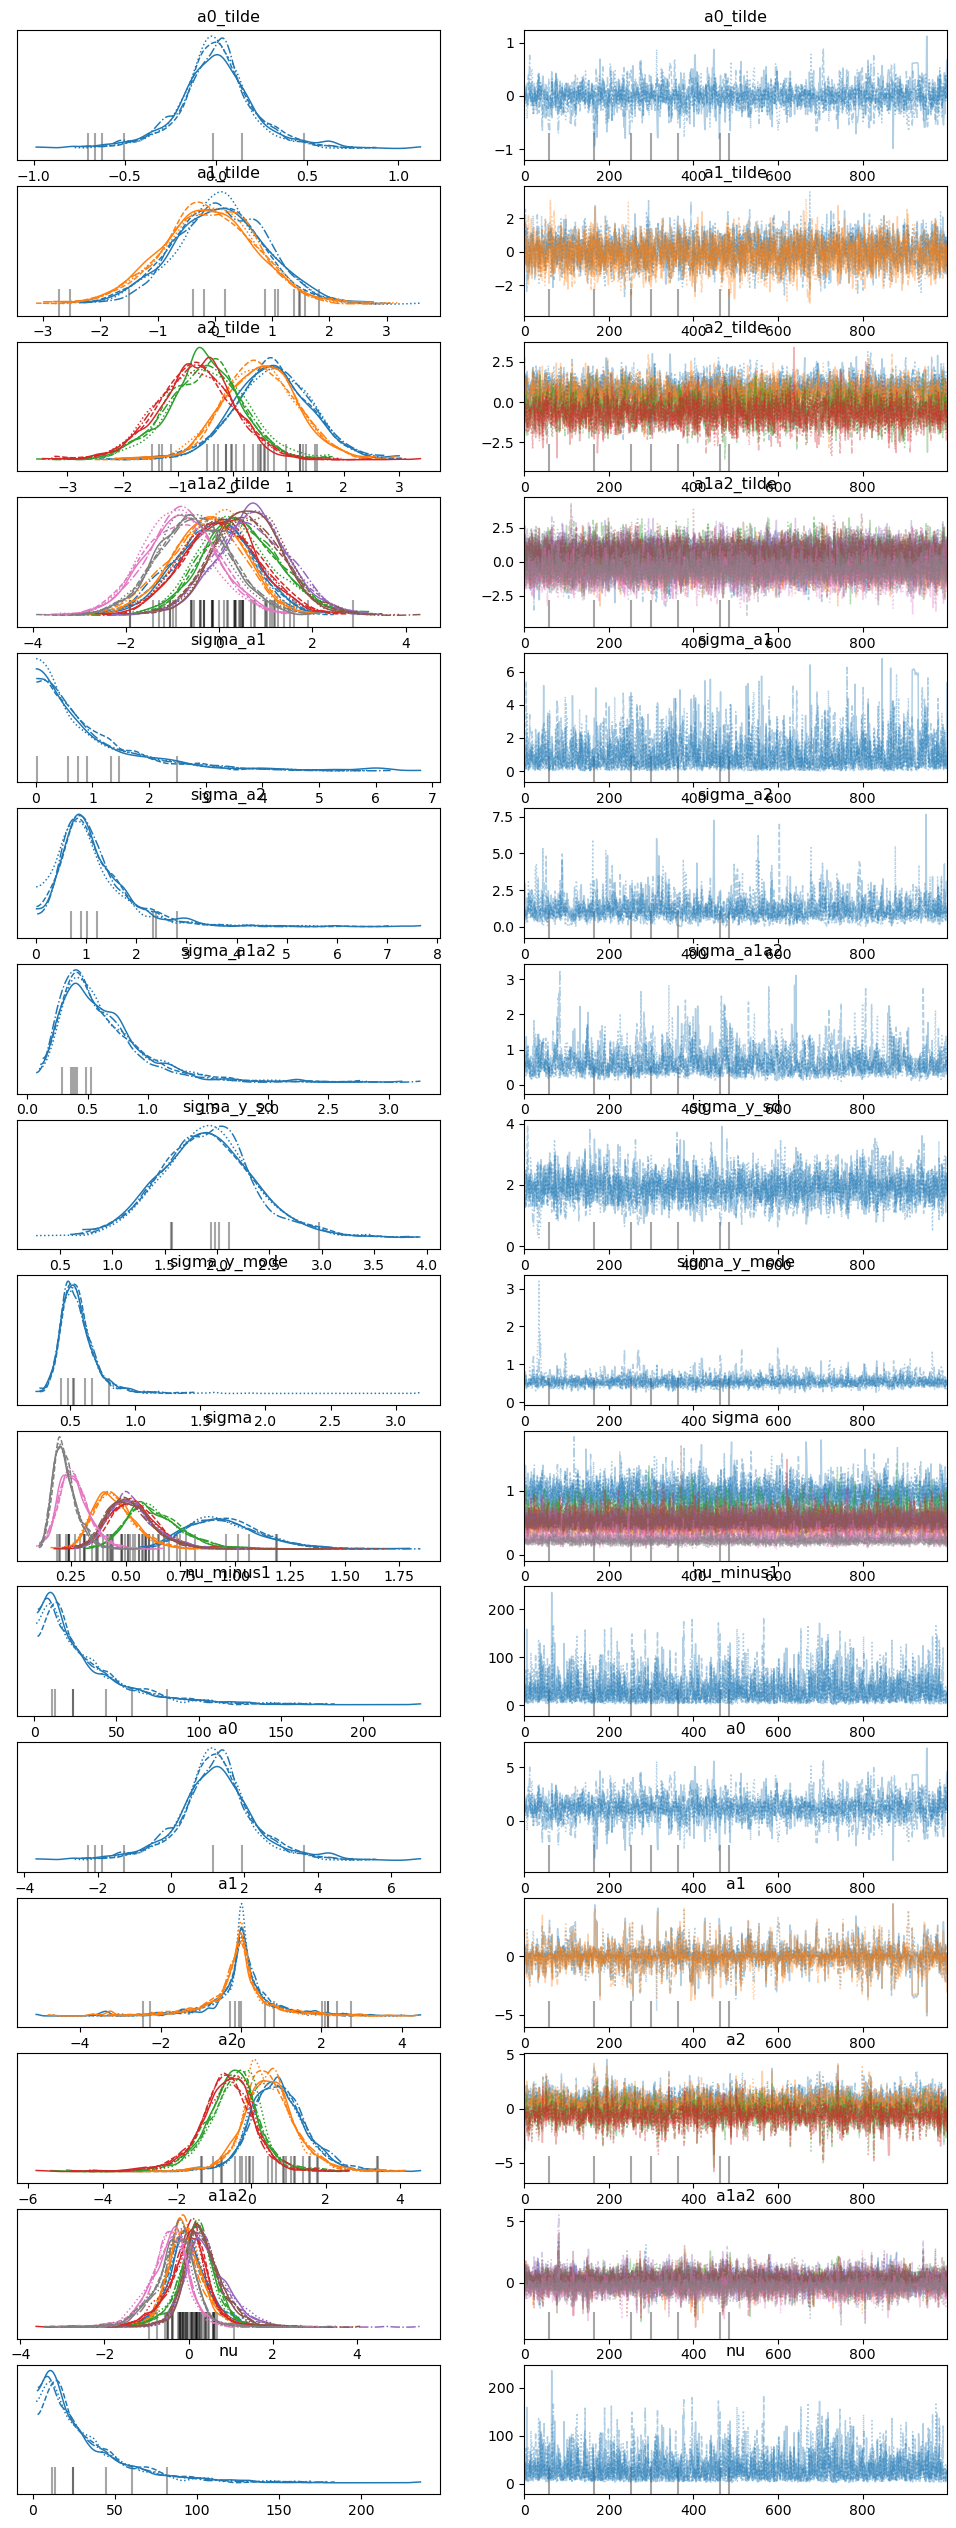

In [470]:
az.plot_trace(idata_Rhist_e1);

In [483]:
post_Rhist_e1 = bst.two_factor_anova_convert_to_sum_to_zero(idata_Rhist_e1, df_trl_hist.group[df_trl_hist.exp==1], df_trl_hist.R_hist[df_trl_hist.exp==1])
post_Rhist_e1 = post_Rhist_e1.rename({"factor1": "group", "factor2": "Reward_hist"})

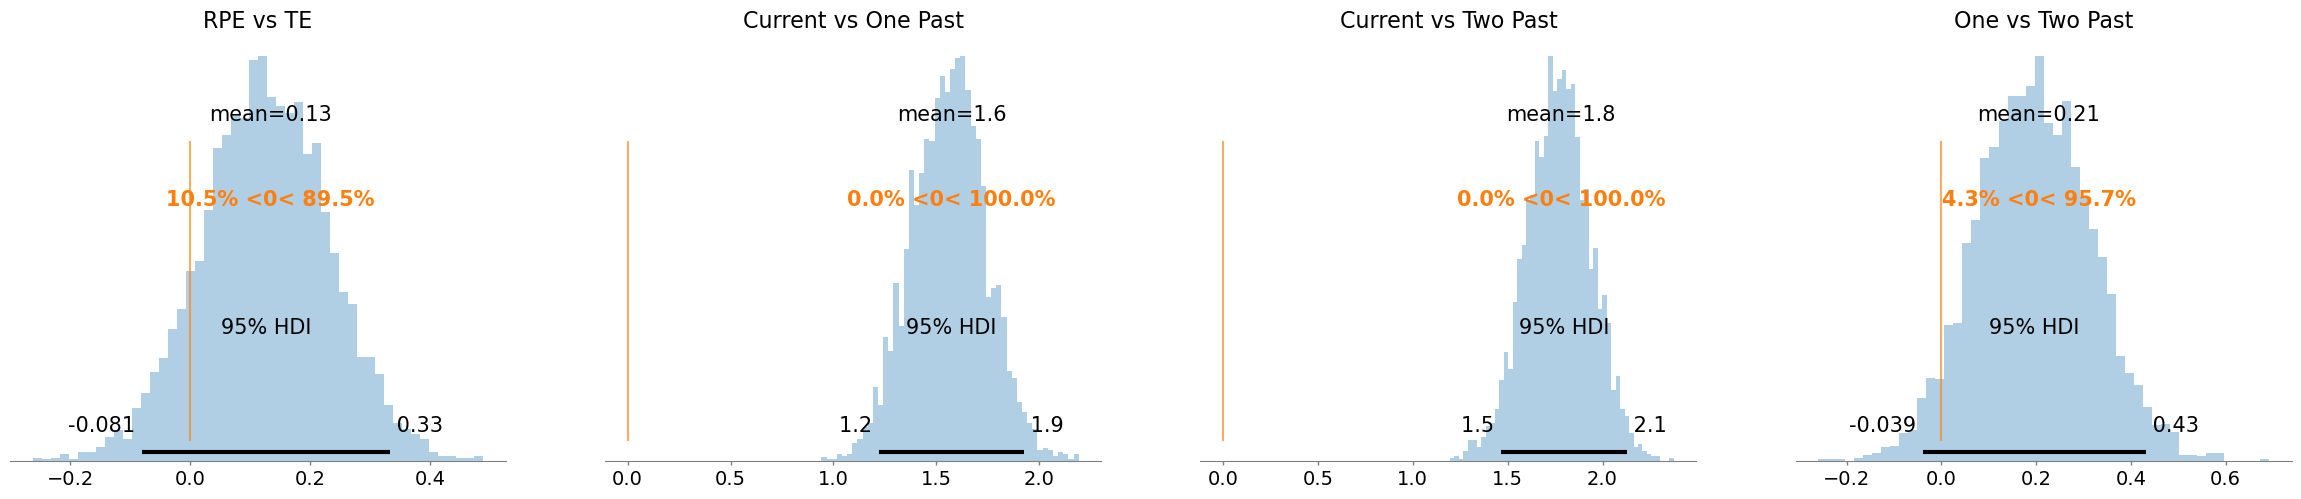

In [485]:
#Main effect constrasts
contrasts = {"RPE vs TE": post_Rhist_e1.b1.sel(group='RPE') - post_Rhist_e1.b1.sel(group='TE'),
            "Current vs One Past": post_Rhist_e1.b2.sel(Reward_hist='Current') - post_Rhist_e1.b2.sel(Reward_hist='One_Past'),
            "Current vs Two Past": post_Rhist_e1.b2.sel(Reward_hist='Current') - post_Rhist_e1.b2.sel(Reward_hist='Two_Past'),
            "One vs Two Past": post_Rhist_e1.b2.sel(Reward_hist='One_Past') - post_Rhist_e1.b2.sel(Reward_hist='Two_Past'),
            }
az.plot_posterior(contrasts, 
                  kind="hist", 
                  bins=50, 
                  point_estimate="mean", 
                  ref_val=0,
                  hdi_prob=0.95);

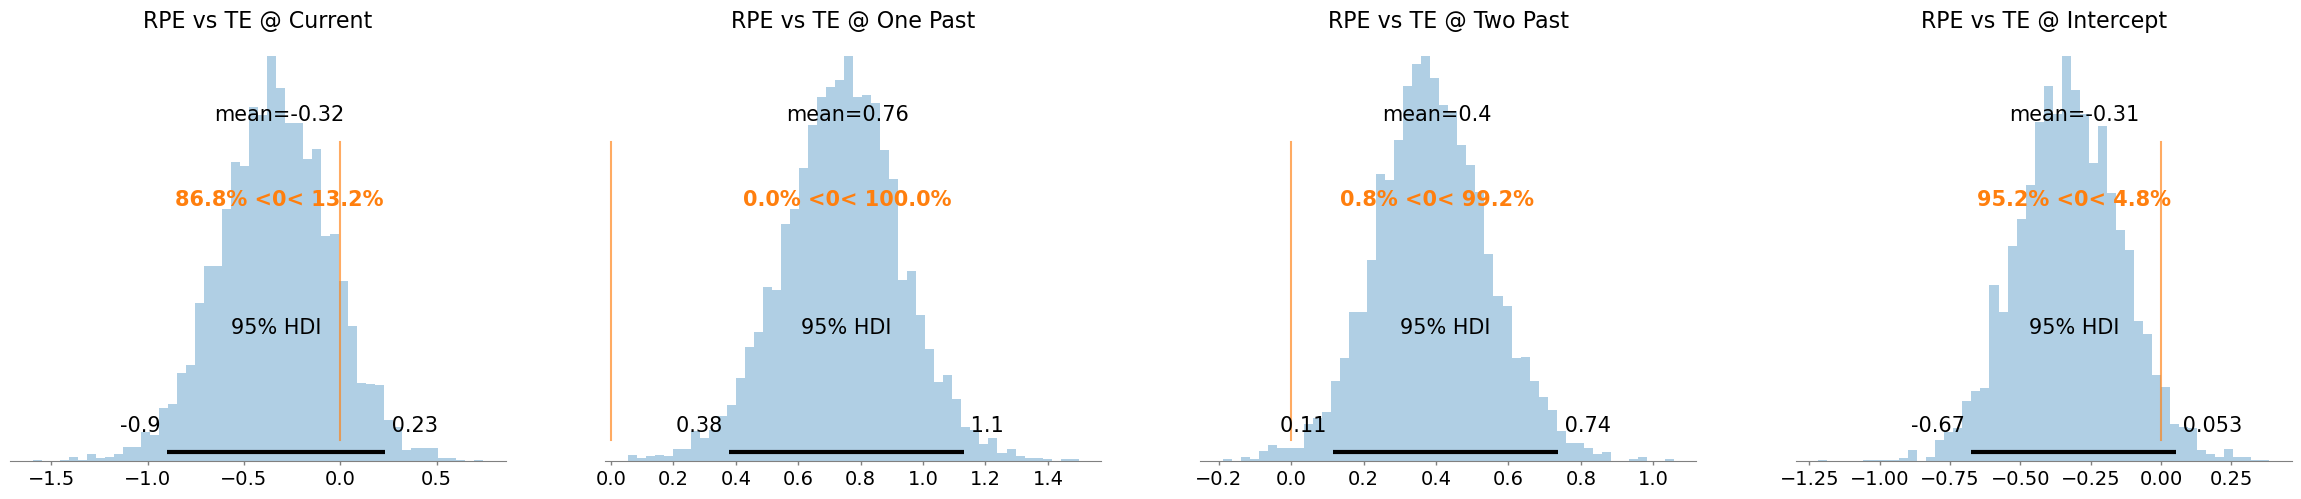

In [487]:
interaction_contrasts = {"RPE vs TE @ Current": post_Rhist_e1.m.sel(group="RPE", Reward_hist="Current") - post_Rhist_e1.m.sel(group="TE", Reward_hist="Current"),
                         "RPE vs TE @ One Past": post_Rhist_e1.m.sel(group="RPE", Reward_hist="One_Past") - post_Rhist_e1.m.sel(group="TE", Reward_hist="One_Past"),
                         "RPE vs TE @ Two Past": post_Rhist_e1.m.sel(group="RPE", Reward_hist="Two_Past") - post_Rhist_e1.m.sel(group="TE", Reward_hist="Two_Past"),
                         "RPE vs TE @ Intercept": post_Rhist_e1.m.sel(group="RPE", Reward_hist="Intercept") - post_Rhist_e1.m.sel(group="TE", Reward_hist="Intercept")}

az.plot_posterior(interaction_contrasts, 
                  kind="hist",
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  hdi_prob=0.95);

## TTC method

### Exp 1

In [432]:
#Run the model
model_ttc_e1, idata_ttc_e1 = bst.BEST(df3.ttc[df3.exp==1], df3.group[df3.exp==1])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_mean, group_std, nu_minus_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


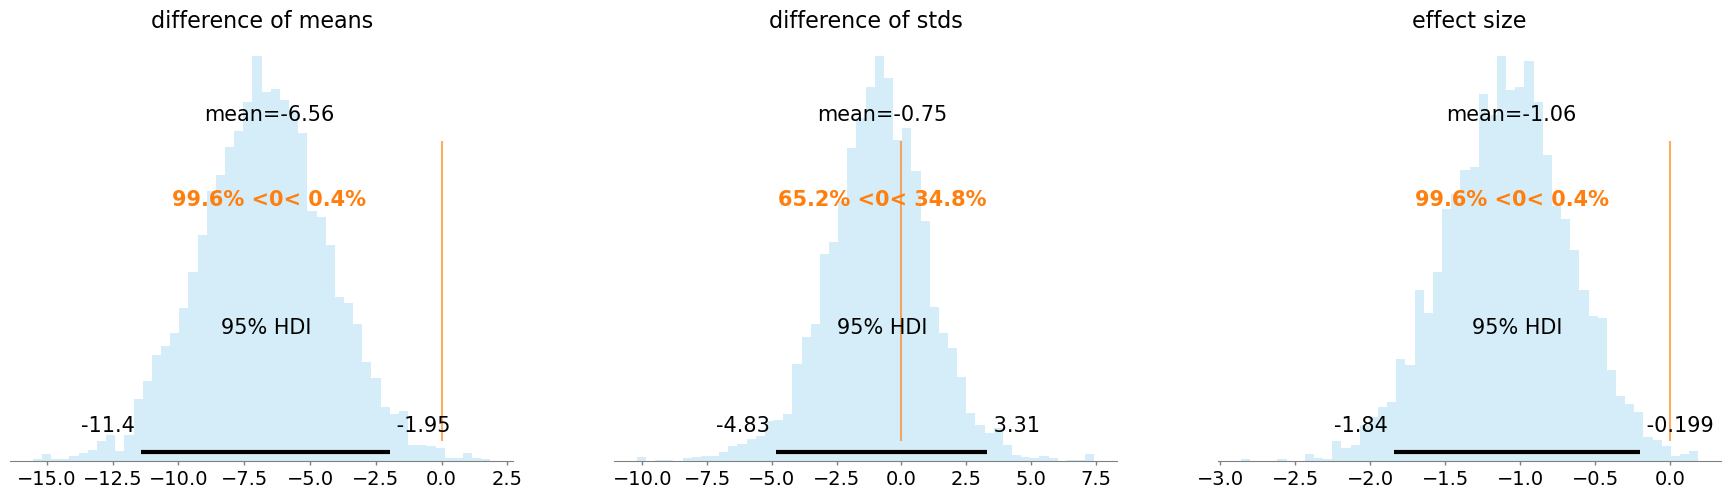

In [433]:
az.plot_posterior(
    idata_ttc_e1,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
    kind="hist",
    round_to=3,
    bins=50,
    hdi_prob=0.95,
);

In [434]:
e1_ttc_summary = az.summary(idata_ttc_e1,hdi_prob=0.95)

print('RPE Correction Trend =', e1_ttc_summary['mean'][0], '[', e1_ttc_summary['hdi_2.5%'][0], e1_ttc_summary['hdi_97.5%'][0], ']')
print('TE Correction Trend =', e1_ttc_summary['mean'][1], '[', e1_ttc_summary['hdi_2.5%'][1], e1_ttc_summary['hdi_97.5%'][1], ']')
print('Difference of means =', e1_ttc_summary['mean'][7], '[', e1_ttc_summary['hdi_2.5%'][7], e1_ttc_summary['hdi_97.5%'][7], ']')

RPE Correction Trend = 7.705 [ 4.506 10.767 ]
TE Correction Trend = 14.261 [ 10.782 17.926 ]
Difference of means = -6.557 [ -11.416 -1.954 ]


### Exp 2

In [435]:
#Run the model
model_ttc_e2, idata_ttc_e2 = bst.BEST(df3.ttc[df3.exp==2], df3.group[df3.exp==2])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_mean, group_std, nu_minus_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


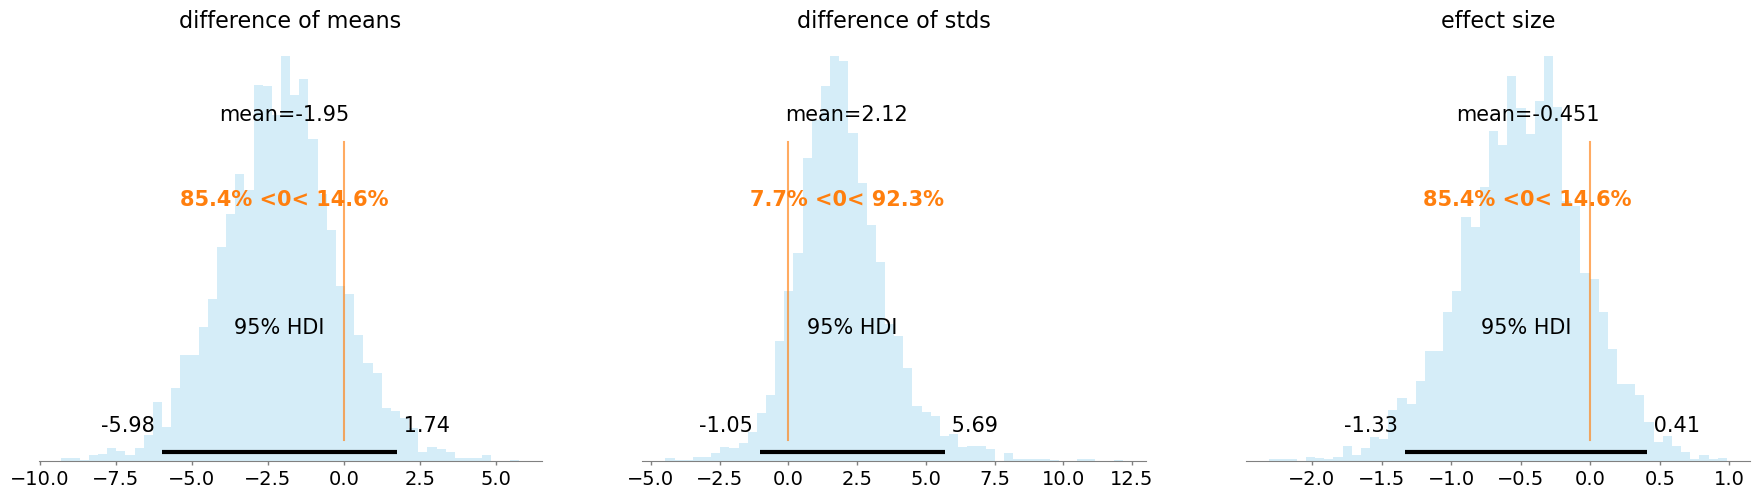

In [436]:
az.plot_posterior(
    idata_ttc_e2,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
    kind="hist",
    round_to=3,
    bins=50,
    hdi_prob=0.95,
);

In [437]:
e2_ttc_summary = az.summary(idata_ttc_e2,hdi_prob=0.95)

print('RPE Correction Trend =', e2_ttc_summary['mean'][0], '[', e2_ttc_summary['hdi_2.5%'][0], e2_ttc_summary['hdi_97.5%'][0], ']')
print('TE Correction Trend =', e2_ttc_summary['mean'][1], '[', e2_ttc_summary['hdi_2.5%'][1], e2_ttc_summary['hdi_97.5%'][1], ']')
print('Difference of means =', e2_ttc_summary['mean'][7], '[', e2_ttc_summary['hdi_2.5%'][7], e2_ttc_summary['hdi_97.5%'][7], ']')

RPE Correction Trend = 7.612 [ 4.409 10.945 ]
TE Correction Trend = 9.561 [ 7.417 11.501 ]
Difference of means = -1.95 [ -5.981 1.738 ]


## ATTC method

### Exp 1

In [438]:
#Run the model
model_attc_e1, idata_attc_e1 = bst.BEST(df3.attc[df3.exp==1], df3.group[df3.exp==1])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_mean, group_std, nu_minus_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


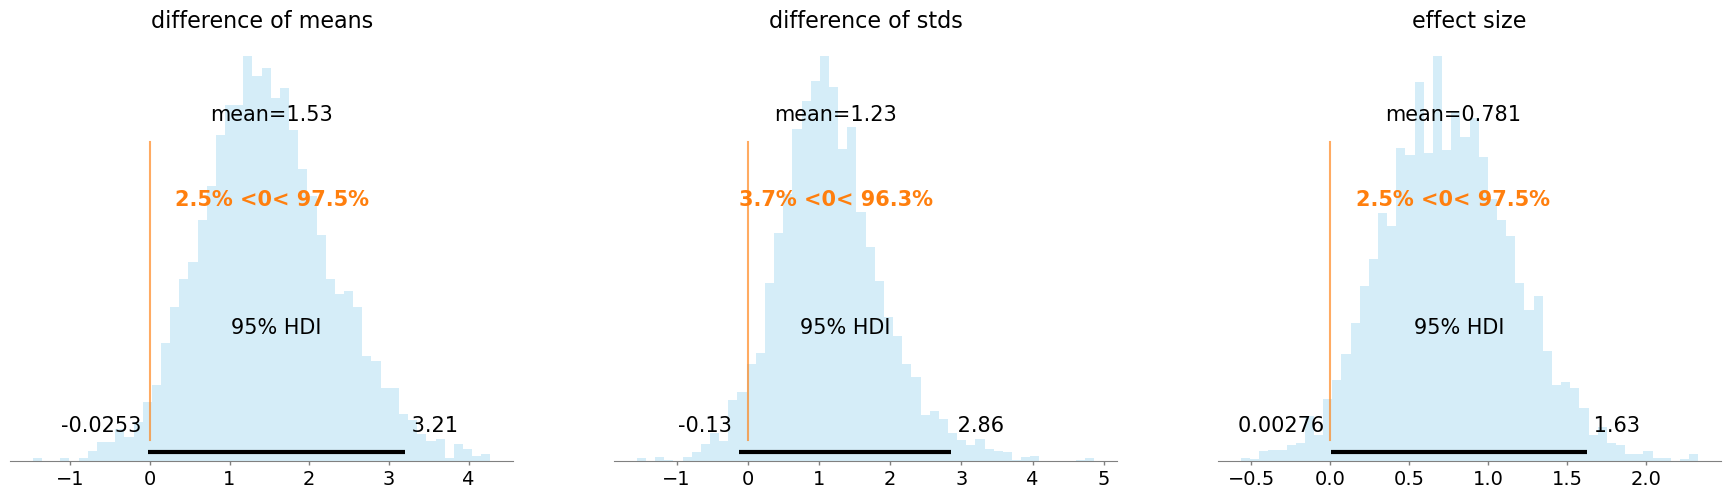

In [439]:
az.plot_posterior(
    idata_attc_e1,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
    kind="hist",
    round_to=3,
    bins=50,
    hdi_prob=0.95,
);

In [440]:
e1_attc_summary = az.summary(idata_attc_e1,hdi_prob=0.95)

print('RPE Correction Trend =', e1_attc_summary['mean'][0], '[', e1_attc_summary['hdi_2.5%'][0], e1_attc_summary['hdi_97.5%'][0], ']')
print('TE Correction Trend =', e1_attc_summary['mean'][1], '[', e1_attc_summary['hdi_2.5%'][1], e1_attc_summary['hdi_97.5%'][1], ']')
print('Difference of means =', e1_attc_summary['mean'][7], '[', e1_attc_summary['hdi_2.5%'][7], e1_attc_summary['hdi_97.5%'][7], ']')

RPE Correction Trend = 2.303 [ 0.797 3.836 ]
TE Correction Trend = 0.774 [ 0.013 1.592 ]
Difference of means = 1.529 [ -0.025 3.206 ]


### Exp 2

In [442]:
#Run the model
model_attc_e2, idata_attc_e2 = bst.BEST(df3.attc[df3.exp==2], df3.group[df3.exp==2])

/Users/jonathanwood/opt/anaconda3/envs/bayes_toolbox/lib/python3.11/site-packages/pymc/model.py:1406: ImputationWarning: Data in likelihood contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_mean, group_std, nu_minus_one, likelihood_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


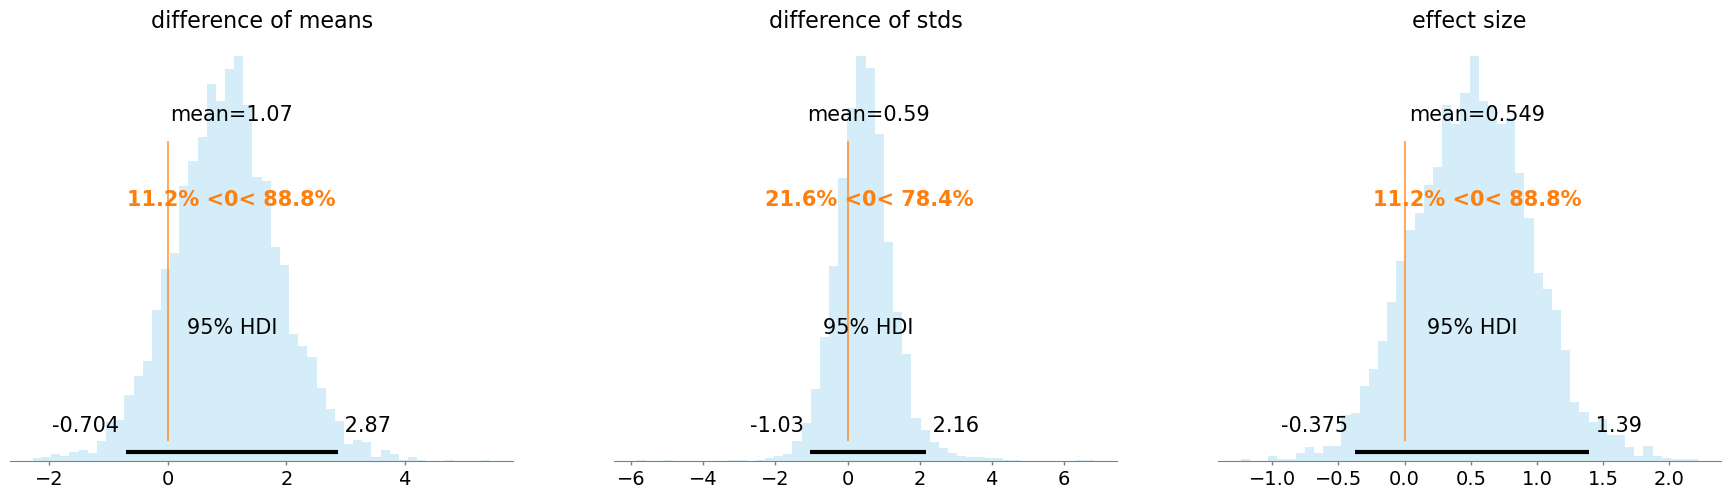

In [443]:
az.plot_posterior(
    idata_attc_e2,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
    kind="hist",
    round_to=3,
    bins=50,
    hdi_prob=0.95,
);

In [444]:
e2_attc_summary = az.summary(idata_attc_e2,hdi_prob=0.95)

print('RPE Correction Trend =', e2_attc_summary['mean'][0], '[', e2_attc_summary['hdi_2.5%'][0], e2_attc_summary['hdi_97.5%'][0], ']')
print('TE Correction Trend =', e2_attc_summary['mean'][1], '[', e2_attc_summary['hdi_2.5%'][1], e2_attc_summary['hdi_97.5%'][1], ']')
print('Difference of means =', e2_attc_summary['mean'][7], '[', e2_attc_summary['hdi_2.5%'][7], e2_attc_summary['hdi_97.5%'][7], ']')

RPE Correction Trend = 1.52 [ 0.203 3.076 ]
TE Correction Trend = 0.453 [ -0.653 1.541 ]
Difference of means = 1.233 [ 0.339 2.067 ]
